## <center>Title: Titanic survived prediction</center>

## THE MAIN OBJECTIVE OF PROJECT
### Determine best model for best score on "titanic" dataset

## Data 

    -  Pclass - passenger class (1 - highest, 2 - middle, 3 - lowest); 

    - Name - name; 

    - Sex - gender; 

    - Age - age; 

    - SibSp - number of brothers, sisters, half-brothers, half-sisters, spouses on board the Titanic;

    - Parch - number of parents, children (including foster children) on board the Titanic; 

    - Embarked - This column stores information about the passenger's port of boarding. There are three possible values for Embarked - Southampton, Scherburg and Queenstown;

    - Ticket - Ticket number of the passenger;

    - Fare - Fare paid by the passenger;

    - Cabin - Cabin number of the passenger;

    - Boat - Lifeboat (if survived);

    - Body - Body number (if did not survive and body was recovered);

    - Survived - Survival (0 = No; 1 = Yes); 

    - Home.dest - Destination of Titanic passengers;

## Models and Tools 

### Models:

     1. Decision tree classifier
     2. Random forest classifier
     3. Support vector classifier
     4. AdaBoost classifier

### Tools:

    1. Feature-engineering techniques 
    2. Feature-selection techniques
    3. Pipelines
    4. Tunning models methods

# 2 - Import libraries

In [1]:
# Linear algebra & statistical analysis
import pandas as pd 
import numpy as np


# Visualisation of data 
import seaborn as sns 
import matplotlib.pyplot as plt


# Model train preparation
from sklearn.model_selection import train_test_split

# Missing value imputation
from feature_engine.imputation import (MeanMedianImputer,
                                       ArbitraryNumberImputer,
                                       EndTailImputer, 
                                       RandomSampleImputer)


# Encoding 
from feature_engine.encoding import (OneHotEncoder,
                                     MeanEncoder,
                                     CountFrequencyEncoder,
                                     OrdinalEncoder,
                                     WoEEncoder)

# Discretization
from feature_engine.discretisation import (EqualWidthDiscretiser,
                                           DecisionTreeDiscretiser,
                                           EqualFrequencyDiscretiser)


# Models (encoding methods perfomance)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Feature-magnitude 
from sklearn.preprocessing import (StandardScaler,
                                   Normalizer,
                                   RobustScaler)

# Metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score


# Feature-selection 
from feature_engine.selection import (DropConstantFeatures,
                                      DropDuplicateFeatures,
                                      SmartCorrelatedSelection)


# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Compose elements
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Save models
import pickle

## Functions 

In [2]:
# Function for groupping variables "sibsp" and "parch" in one binary feature "loneless" and drop not needed features
def groupping_and_drop(df):
    
    tmp_df = df.copy()
    tmp_array = np.array(pd.concat([df['sibsp'], df['parch']], axis = 1))
    tmp_list = []
    
    for i, j in tmp_array:
        if i == 0 and j == 0:
            tmp_list.append('alone')
        else:
            tmp_list.append('not alone')

    df['loneless'] = tmp_list
    
    # Checking correctness of creation feature "loneless"
    
    print('Checking correctness of loneless: \n')
    print(df[['sibsp', 'parch', 'loneless']].head(15))
    
    df.drop(
        labels = ['sibsp', 'parch'],
        axis = 1,
        inplace = True
    )
    
    return df




# Function for compare distribution and variance of imputed set and entire set
def check_dist_and_variance(df_before, df_after, var):
    
    
    if df_before[var].dtype == 'O' and df_after[var].dtype == 'O':
        print('Categorical variable')
        sns.histplot(data[var], color = 'brown')
        
    else:
        print('Variance before imputation: {}\n' .format(df_before[var].var()))
        print('Variance after imputation: {}' .format(df_after[var].var()))
        
    
    fig = plt.figure(figsize = (12, 5))
    
    ax = fig.add_subplot(1, 2, 1)
    sns.histplot(df_before[var])
    plt.title('{} before imputation' .format(var))
    
    ax = fig.add_subplot(1, 2, 2)
    sns.histplot(df_after[var])
    plt.title('{} after imputation' .format(var))
    
    plt.show()
    
    
    
    
# Check relationships of any predictor with target by mean value 
def check_relationship_with_target(train_t, y_train_test, var):
    
    pd.concat([train_t, y_train_test], axis = 1).groupby(var)['survived'].mean().plot()
    plt.title(var)
    plt.ylabel('mean of survived')
    plt.show()
    
    
# Graphic for checking rare labels 
def check_rare_labels(df, lst):
    
    for col in lst:
    
        temp_df = pd.Series(df[col].value_counts() / len(df))
    
        fig = temp_df.sort_values(ascending = False).plot.bar()
        fig.set_xlabel(col)
        fig.axhline(y = 0.05, color = 'red')
        fig.set_ylabel('Percentage')
        
        plt.show()
        
        
# Check balancing of unique features after discretisation         
def check_balance_of_discretized(train_t, test_t, var):
    
    t1 = train_t.groupby([var])[var].count() / len(train_t)
    t2 = test_t.groupby([var])[var].count() / len(test_t)

    tmp = pd.concat([t1, t2], axis = 1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.xticks(rotation = 0)
    plt.ylabel('Number of observations per bin')
    plt.show()
    
    
# Probability plots after and before scaling  
def probplot_scaled(before_set, after_set):
    
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(12, 5))

    # Before scaling

    ax1.set_title('Before Scaling')
    sns.kdeplot(before_set, ax = ax1)
    sns.kdeplot(before_set, ax = ax1)
    sns.kdeplot(before_set, ax = ax1)

    # After Scaling
    ax2.set_title('After Scaling')
    sns.kdeplot(after_set, ax = ax2)
    sns.kdeplot(after_set, ax = ax2)
    sns.kdeplot(after_set, ax = ax2)

    plt.show()
    
# Get metrcs score on trained / tuned model 
def get_score(estimator):
    
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    
    fig = plt.figure(figsize = (12, 4))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.title('Train set')
    sns.heatmap(confusion_matrix(y_train, y_pred_train), annot = True)
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title('Test set')
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True)
    
    plt.show()
    

    print('Classification report on train set\n ', classification_report(y_train, y_pred_train), '\n\n')
    print('Classification report on test set\n ', classification_report(y_test, y_pred_test))

# 3 - Data analysis

## Overview of dataset

In [3]:
# Load dataset and check shape of it
data = pd.read_csv('titanic.csv')

data.shape

(1309, 14)

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
survived,1309.0,0.381971,0.486055,0.0000,0.0000,0.0000,1.000,1.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000


 Some of features have unusual parameters that we need to search

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


 We have:
 - 3 - float,
 - int64 - 4,
 - object - 7 features 

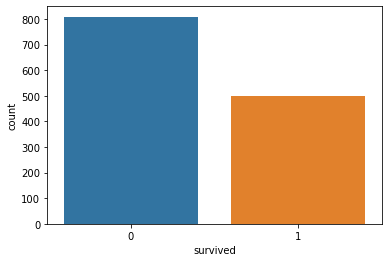

In [6]:
sns.countplot(x = data['survived'], label = 'Count')
plt.show()

 Overview of balance of target classes, balance are permissible 

## Split features from dataset on lists by types

In [7]:
# Split into lists of features by types 

categorical = [var for var in data.columns if data[var].dtype == 'O' and var != 'survived']

# Сheck the correctness of the definition of variables

print('Count of categorical features: ', len(categorical))
print('Count of all features: ', len(data.columns), '\n')

for var in categorical:
    print('\n', var, ': \n', data[var].unique(), '\n')

Count of categorical features:  7
Count of all features:  14 


 name : 
 ['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo'] 


 sex : 
 ['female' 'male'] 


 ticket : 
 ['24160' '113781' '19952' '13502' '112050' '11769' 'PC 17609' 'PC 17757'
 'PC 17477' '19877' '27042' 'PC 17318' 'PC 17558' '11813' '13050' '11751'
 '111369' 'PC 17483' '13905' '11967' 'PC 17760' '110564' '113784' '112277'
 '36928' '113783' '110489' 'PC 17608' '113505' '111427' '113054'
 'PC 17591' '112379' 'PC 17610' '16966' '113050' '113798' 'PC 17476'
 'PC 17606' 'PC 17755' '695' '113059' '113760' '19924' '17770'
 'W.E.P. 5734' '113806' '110152' 'PC 17594' '112051' '13508' '110465'
 '5727' 'PC 17756' '11770' '113791' 'WE/P 5735' '112901' 'PC 17599'
 '113055' '113804' 'F.C. 12750' '17474' '33638' 'PC 17761' '11755'
 'PC 17485' 'PC 17580' '11767' '36947' 'PC 17531' 'PC 17598' '17421'
 'PC 17474' '

 All of selected features have categorical type

In [8]:
# Create list of numerical features,
# than split this list on 2 types of numerical: continous / discrete 

numerical = [var for var in data.columns if var not in categorical and var != 'survived']

continous = [var for var in numerical if data[var].nunique() > 15]

discrete = [var for var in numerical if data[var].nunique() <= 15 and var not in continous]

# Check correctness of created lists (discrete, continous, numerical)


print('Count of numerical features: ', len(numerical))

print('Count of continous features: ', len(continous))

print('Count of numerical features: ', len(numerical), '\n')

print('Numerical features: \n', numerical, '\n')

print('Continous features: \n', continous, '\n')

print('Discrete features: \n', discrete)

Count of numerical features:  6
Count of continous features:  3
Count of numerical features:  6 

Numerical features: 
 ['pclass', 'age', 'sibsp', 'parch', 'fare', 'body'] 

Continous features: 
 ['age', 'fare', 'body'] 

Discrete features: 
 ['pclass', 'sibsp', 'parch']


 Should make sure that the correct variables are in the lists

 We can make sure than continous and discrete features are on thier places by histogram

Continous features histograms: 



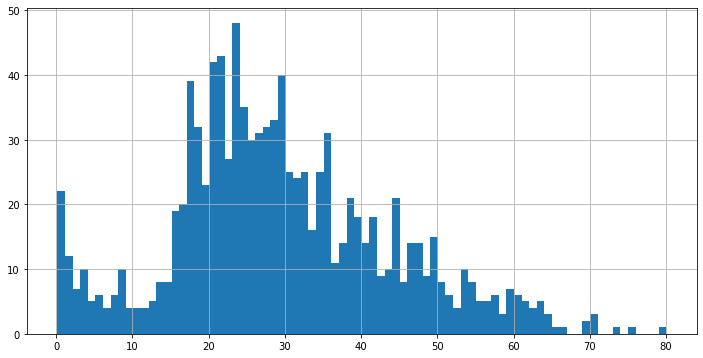

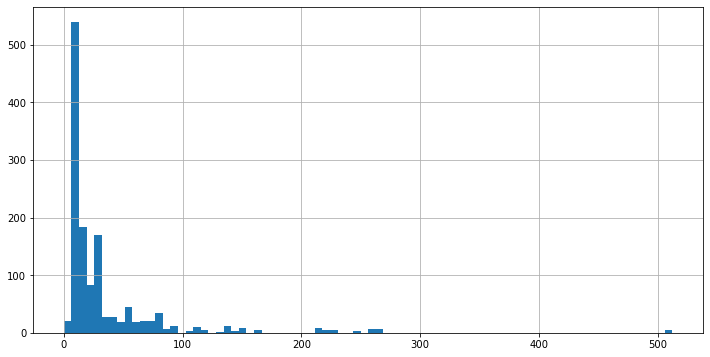

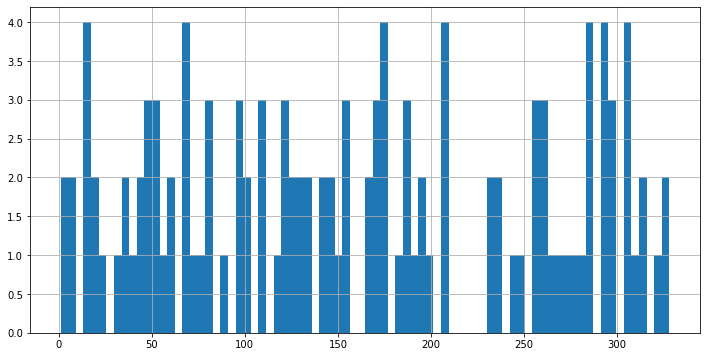

In [9]:
plt.rcParams['figure.figsize'] = (12, 6)

print('Continous features histograms: \n')

for var in continous:
    data[var].hist(bins = 80)
    plt.show()

Discrete features histograms: 



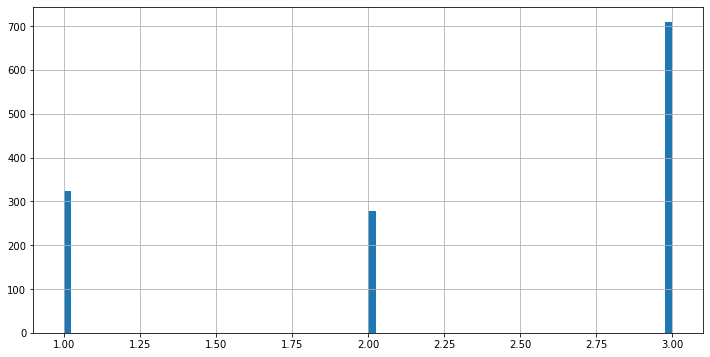

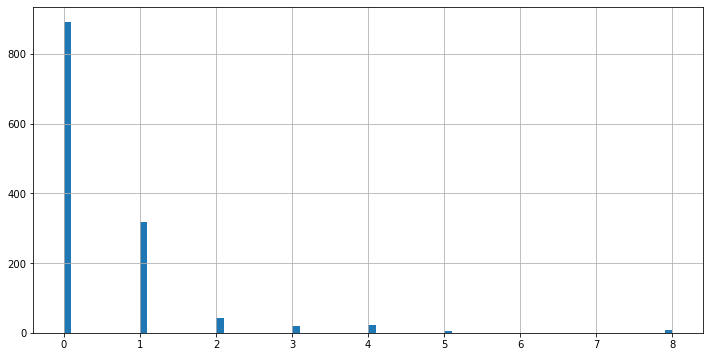

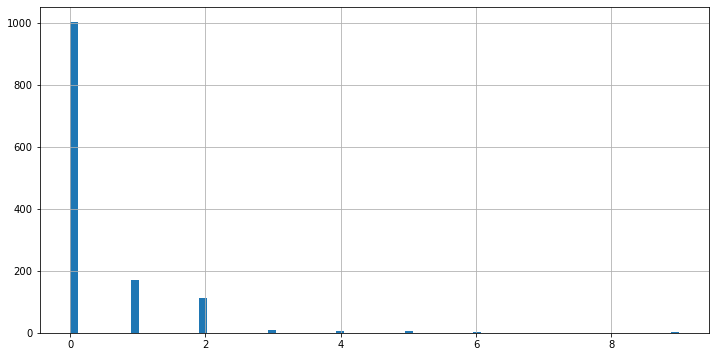

In [10]:
print('Discrete features histograms: \n')

for var in discrete:
    data[var].hist(bins = 80)
    plt.show()

     Got a proof that the variables of numerical features are in their lists

     Check cardinality of categorical features

In [11]:
data[categorical].nunique()

name         1307
sex             2
ticket        929
cabin         181
embarked        3
boat           27
home.dest     369
dtype: int64

     Features: "name", "ticket" are high cardinality features
     Also "home.dest" have 369 unique observations and we have assumtions that home.dest feature don't have influence on prediction

In [12]:
print('Categorical features: ', categorical, '\n')

print('Numerical features: ', numerical, '\n')

print('Discrete features: ', discrete, '\n')

print('Continous features: ', continous, '\n')

len(numerical), len(categorical), len(data.columns)

Categorical features:  ['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest'] 

Numerical features:  ['pclass', 'age', 'sibsp', 'parch', 'fare', 'body'] 

Discrete features:  ['pclass', 'sibsp', 'parch'] 

Continous features:  ['age', 'fare', 'body'] 



(6, 7, 14)

     Summary check lists of features

     Than we can search mixed and date&time features that we need to handle or drop from dataset

In [13]:
for var in categorical:
    print(var, '\n')
    print(data[var].unique(), '\n')

name 

['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo'] 

sex 

['female' 'male'] 

ticket 

['24160' '113781' '19952' '13502' '112050' '11769' 'PC 17609' 'PC 17757'
 'PC 17477' '19877' '27042' 'PC 17318' 'PC 17558' '11813' '13050' '11751'
 '111369' 'PC 17483' '13905' '11967' 'PC 17760' '110564' '113784' '112277'
 '36928' '113783' '110489' 'PC 17608' '113505' '111427' '113054'
 'PC 17591' '112379' 'PC 17610' '16966' '113050' '113798' 'PC 17476'
 'PC 17606' 'PC 17755' '695' '113059' '113760' '19924' '17770'
 'W.E.P. 5734' '113806' '110152' 'PC 17594' '112051' '13508' '110465'
 '5727' 'PC 17756' '11770' '113791' 'WE/P 5735' '112901' 'PC 17599'
 '113055' '113804' 'F.C. 12750' '17474' '33638' 'PC 17761' '11755'
 'PC 17485' 'PC 17580' '11767' '36947' 'PC 17531' 'PC 17598' '17421'
 'PC 17474' '113051' '19950' '113778' 'PC 17611' '17765' '13568' '13567'
 '112058' '1138

     Determine mixed features: "ticket", "cabin", "boat"
     Date&Time features were not found

     Than we need to explore more detail these features to decide what we can do with them

## Handle mixed features

### "ticket"

In [14]:
data['ticket'].unique()

array(['24160', '113781', '19952', '13502', '112050', '11769', 'PC 17609',
       'PC 17757', 'PC 17477', '19877', '27042', 'PC 17318', 'PC 17558',
       '11813', '13050', '11751', '111369', 'PC 17483', '13905', '11967',
       'PC 17760', '110564', '113784', '112277', '36928', '113783',
       '110489', 'PC 17608', '113505', '111427', '113054', 'PC 17591',
       '112379', 'PC 17610', '16966', '113050', '113798', 'PC 17476',
       'PC 17606', 'PC 17755', '695', '113059', '113760', '19924',
       '17770', 'W.E.P. 5734', '113806', '110152', 'PC 17594', '112051',
       '13508', '110465', '5727', 'PC 17756', '11770', '113791',
       'WE/P 5735', '112901', 'PC 17599', '113055', '113804',
       'F.C. 12750', '17474', '33638', 'PC 17761', '11755', 'PC 17485',
       'PC 17580', '11767', '36947', 'PC 17531', 'PC 17598', '17421',
       'PC 17474', '113051', '19950', '113778', 'PC 17611', '17765',
       '13568', '13567', '112058', '113803', '111320', '113503', '112378',
       'PC 17593

In [15]:
# Parse feature "ticket" on two parts, numerical and categorical

data['ticket_num'] = data['ticket'].apply(lambda s: s.split()[-1])
data['ticket_num'] = pd.to_numeric(
    data['ticket_num'],
    errors = 'coerce',
    downcast = 'integer'
)

data['ticket_cat'] = data['ticket'].apply(lambda s: s.split()[0])

data['ticket_cat'] = np.where(data['ticket_cat'].str.isdigit(), np.nan, data['ticket_cat'])

 After separation dataset on two features we can explore characteristics of new features 

In [16]:
# Make the overview 

data[['ticket', 'ticket_num', 'ticket_cat']].head(10)

,ticket,ticket_num,ticket_cat
0,24160,24160.0,NaN
1,113781,113781.0,NaN
2,113781,113781.0,NaN
3,113781,113781.0,NaN
4,113781,113781.0,NaN
5,19952,19952.0,NaN
6,13502,13502.0,NaN
7,112050,112050.0,NaN
8,11769,11769.0,NaN
9,PC 17609,17609.0,PC


In [17]:
# categorical version of ticket have Nan values,
# so we can get percentage of Nan observations in new two features

data[['ticket', 'ticket_num', 'ticket_cat']].isnull().mean().apply(lambda x: x * 100)

ticket         0.000000
ticket_num     0.305577
ticket_cat    73.109244
dtype: float64

     Percentage of created Nan observations in feature "ticket_cat" are 73% 
     We can drop this feature

     Than we can check cardinality of new features

In [18]:
data[['ticket', 'ticket_cat', 'ticket_num']].nunique()

ticket        929
ticket_cat     50
ticket_num    923
dtype: int64

 "ticket_num" feature have high cardinality, that can be reason to drop this feature

### "cabin"

In [19]:
data['cabin'].unique()

array(['B5', 'C22', 'E12', 'D7', 'A36', 'C101', nan, 'C62', 'B35', 'A23',
       'B58', 'D15', 'C6', 'D35', 'C148', 'C97', 'B49', 'C99', 'C52', 'T',
       'A31', 'C7', 'C103', 'D22', 'E33', 'A21', 'B10', 'B4', 'E40',
       'B38', 'E24', 'B51', 'B96', 'C46', 'E31', 'E8', 'B61', 'B77', 'A9',
       'C89', 'A14', 'E58', 'E49', 'E52', 'E45', 'B22', 'B26', 'C85',
       'E17', 'B71', 'B20', 'A34', 'C86', 'A16', 'A20', 'A18', 'C54',
       'C45', 'D20', 'A29', 'C95', 'E25', 'C111', 'C23', 'E36', 'D34',
       'D40', 'B39', 'B41', 'B102', 'C123', 'E63', 'C130', 'B86', 'C92',
       'A5', 'C51', 'B42', 'C91', 'C125', 'D10', 'B82', 'E50', 'D33',
       'C83', 'B94', 'D49', 'D45', 'B69', 'B11', 'E46', 'C39', 'B18',
       'D11', 'C93', 'B28', 'C49', 'B52', 'E60', 'C132', 'B37', 'D21',
       'D19', 'C124', 'D17', 'B101', 'D28', 'D6', 'D9', 'B80', 'C106',
       'B79', 'C47', 'D30', 'C90', 'E38', 'C78', 'C30', 'C118', 'D36',
       'D48', 'D47', 'C105', 'B36', 'B30', 'D43', 'B24', 'C2', 'C65',


In [20]:
print(data['cabin'].isnull().mean() * 100, '%')

77.46371275783041 %


 Feature "cabin" have high percentage of missing labels and we drop it 

#### "boat"

In [21]:
data['boat'].unique()

array(['2', '11', nan, '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5',
       '7', 'C', '14', '5 9', '13', '1', '15', '5 7', '8 10', '12', '16',
       '13 15 B', 'C D', '15 16', '13 15'], dtype=object)

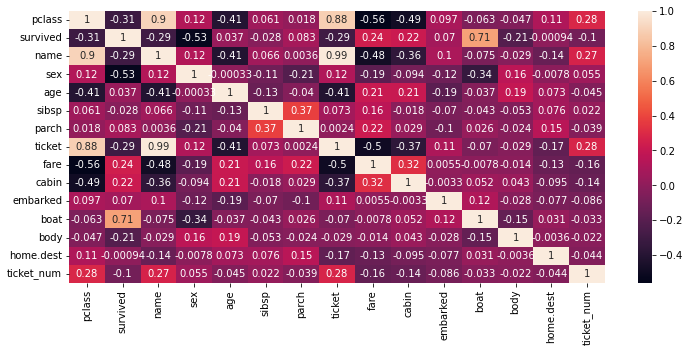

In [22]:
enc_boat = OrdinalEncoder(encoding_method = 'arbitrary', variables = categorical)

data_corr_maxtrix = enc_boat.fit_transform(data.fillna(0))


plt.figure(figsize = (12, 5))
sns.heatmap(data_corr_maxtrix.corr(numeric_only = True), annot = True)
plt.show()

     We got one more reason to drop feature "ticket" - it's have high correlation with feature "pclass"

     Can drop feature "boat" because it have high correlation with target

# Data preprocessing & Feature-engineering

## Drop not needed features

In [23]:
data.drop(
    labels = ['ticket', 'ticket_cat', 'ticket_num', 'boat', 'cabin', 'home.dest', 'name', 'body'],
    axis = 1, 
    inplace = True
)

## Splitting dataset on train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels = 'survived', axis = 1),
    data['survived'],
    test_size = 0.3, 
)

X_train.shape, X_test.shape

((916, 7), (393, 7))

### Create new features

In [25]:
X_train = groupping_and_drop(X_train)

Checking correctness of loneless: 

      sibsp  parch   loneless
1132      0      0      alone
739       0      1  not alone
1194      0      0      alone
766       0      0      alone
946       0      0      alone
645       0      0      alone
199       0      0      alone
828       5      2  not alone
219       0      0      alone
320       0      0      alone
975       1      0  not alone
1124      0      0      alone
695       0      0      alone
603       1      1  not alone
402       1      0  not alone


In [26]:
X_test = groupping_and_drop(X_test)

Checking correctness of loneless: 

      sibsp  parch   loneless
701       0      0      alone
77        1      1  not alone
924       0      0      alone
1254      0      0      alone
983       0      0      alone
414       1      0  not alone
558       0      2  not alone
209       1      0  not alone
458       0      0      alone
897       0      0      alone
1228      0      0      alone
32        0      0      alone
969       1      0  not alone
115       1      4  not alone
554       0      0      alone


In [27]:
X_train.shape, X_test.shape

((916, 6), (393, 6))

## Missing labels

In [28]:
# Determine missing labels in features and get percentage of missing labels

for var in X_train.columns:
    print(var, '\n percentage of missing values: {:.3f}' .format(X_train[var].isnull().mean() * 100), '% \n')

pclass 
 percentage of missing values: 0.000 % 

sex 
 percentage of missing values: 0.000 % 

age 
 percentage of missing values: 21.288 % 

fare 
 percentage of missing values: 0.000 % 

embarked 
 percentage of missing values: 0.109 % 

loneless 
 percentage of missing values: 0.000 % 



In [29]:
data['embarked']

0       S
1       S
2       S
3       S
4       S
       ..
1304    C
1305    C
1306    C
1307    C
1308    S
Name: embarked, Length: 1309, dtype: object

In [30]:
# Make lists of numerical and categorical features for missing data imputation

impute_num = ['age', 'fare']

impute_cat = ['embarked']

### Numerical data imputation

#### Mean/Median imputation

##### Mean imputation

In [31]:
impute_mean = MeanMedianImputer(imputation_method = 'mean', variables = ['age', 'fare'])

X_train_imputed_mean = impute_mean.fit_transform(X_train)

Variance before imputation: 210.70002243515734

Variance after imputation: 165.79673896536977


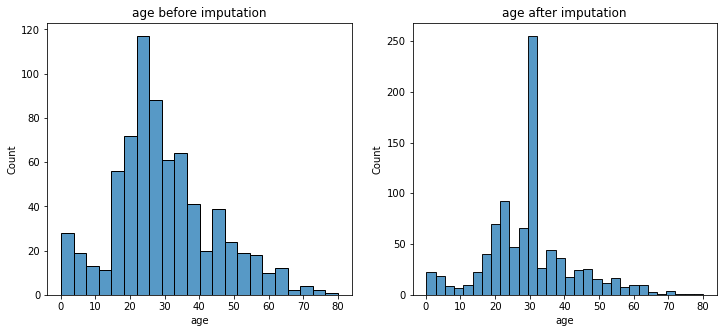

Variance before imputation: 2813.6917741825073

Variance after imputation: 2813.6917741825073


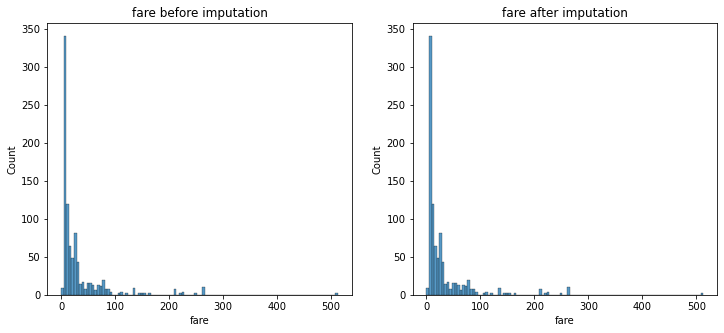

In [32]:
for var in impute_num:
    check_dist_and_variance(X_train, X_train_imputed_mean, var)

     Have significant chancges of distribution in feature "age",
     this is explained 20% of Nan values in this features

     Feature "fare" almost don't change because it have small percentage of Nan values
     and missing data imputation practically don't have influence on distribution and variance

##### Median imputation

Variance before imputation: 210.70002243515734

Variance after imputation: 167.0843733816828


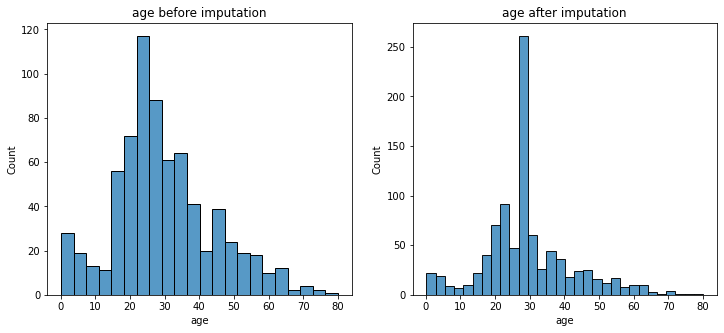

Variance before imputation: 2813.6917741825073

Variance after imputation: 2813.6917741825073


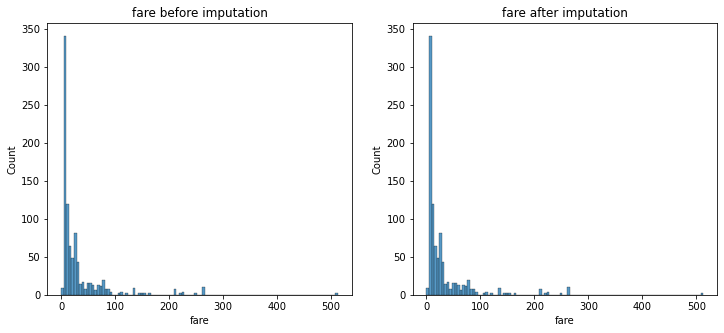

In [33]:
impute_median = MeanMedianImputer(imputation_method = 'median', variables = ['age', 'fare'])

X_train_imputed_median = impute_median.fit_transform(X_train)

for var in impute_num:
    check_dist_and_variance(X_train, X_train_imputed_median, var)

     Imputation by median value have practically the same results like with mean imputation 

### Both imputation techniques

#### Random sample imputation

Categorical variable


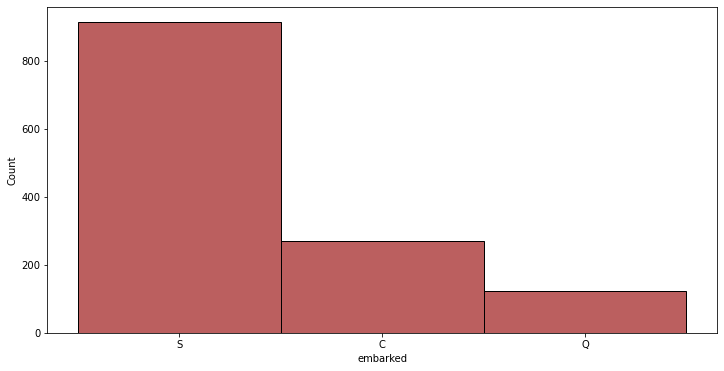

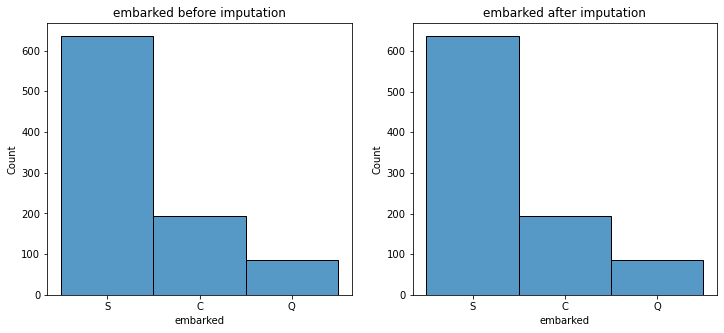

Variance before imputation: 210.70002243515734

Variance after imputation: 190.75957871742648


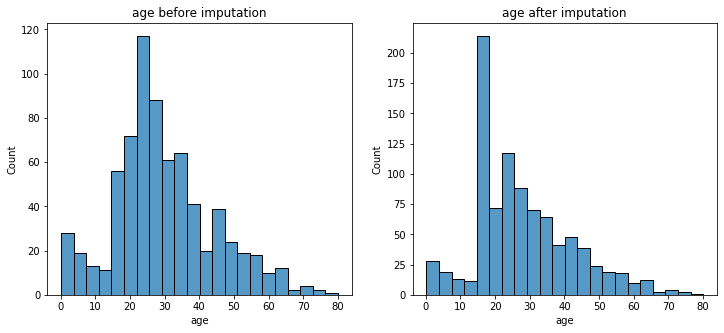

Variance before imputation: 2813.6917741825073

Variance after imputation: 2813.6917741825073


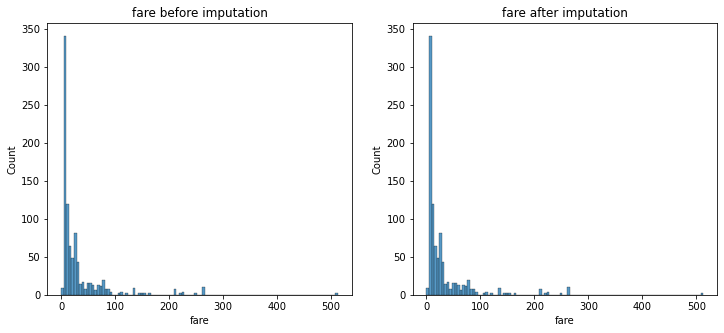

In [34]:
impute_random_sample = RandomSampleImputer(
    variables = impute_cat + impute_num,
    seed = 'observation',
    random_state = 'pclass'
)


X_train_imputed_random_sample = impute_random_sample.fit_transform(X_train)


for var in impute_cat + impute_num:
    check_dist_and_variance(X_train, X_train_imputed_random_sample, var)

                  We get less changes in statistical characteristics in features by this method, the problem of randomness we can decide by using random_state, and control it by some feature from dataset or some integer value

Categorical variable


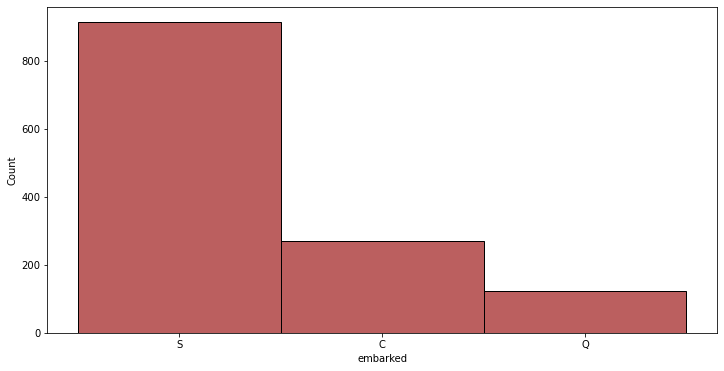

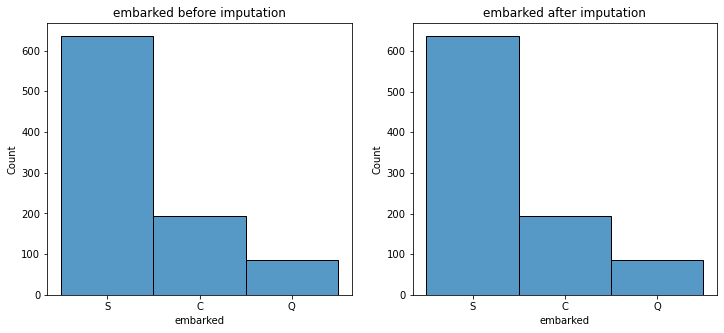

Variance before imputation: 210.70002243515734

Variance after imputation: 206.32542510112773


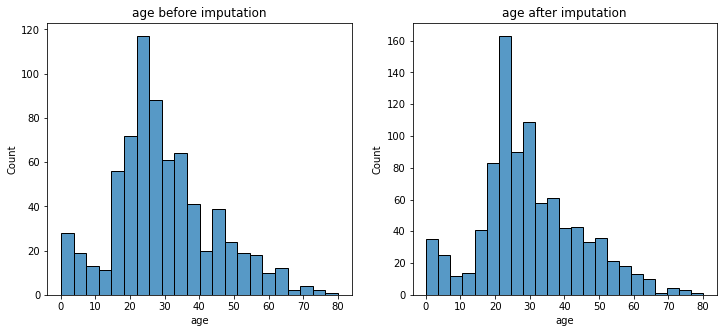

Variance before imputation: 2813.6917741825073

Variance after imputation: 2813.6917741825073


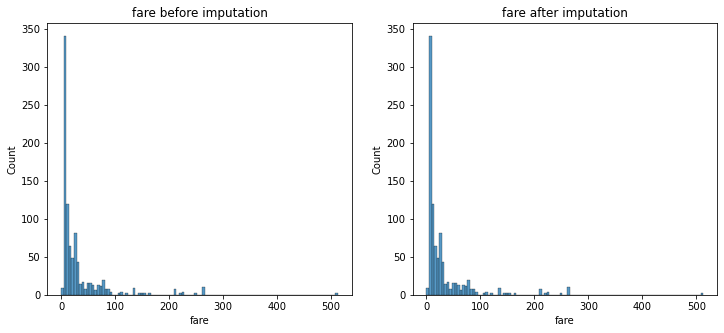

In [35]:
impute_random_sample = RandomSampleImputer(
    variables = impute_cat + impute_num,
    random_state = 44 
)


X_train_imputed_random_sample = impute_random_sample.fit_transform(X_train)

X_test_imputed_random_sample = impute_random_sample.transform(X_test)


for var in impute_cat+impute_num:
    check_dist_and_variance(X_train, X_train_imputed_random_sample, var)

     We got the best result from random_sample imputation with set random_state paraemter equals 4

     When we will tune hyperparameters for model maybe we can find better number for random_state hyperparameter

## Encoding rare labels

In [36]:
# Redefine variable categorical because we drop some of categorical features from original dataset earlier

categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']

categorical

['sex', 'embarked', 'loneless']

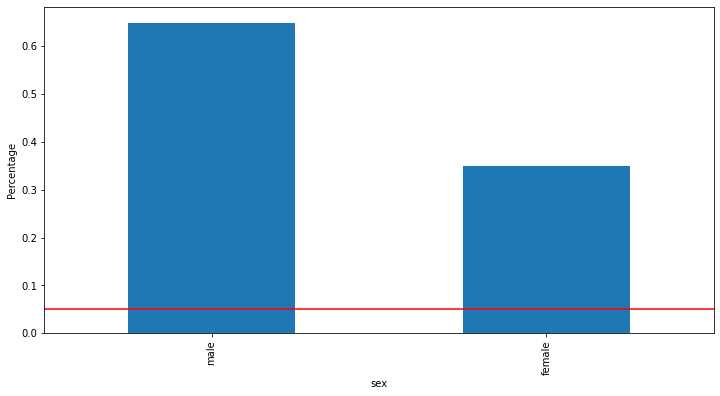

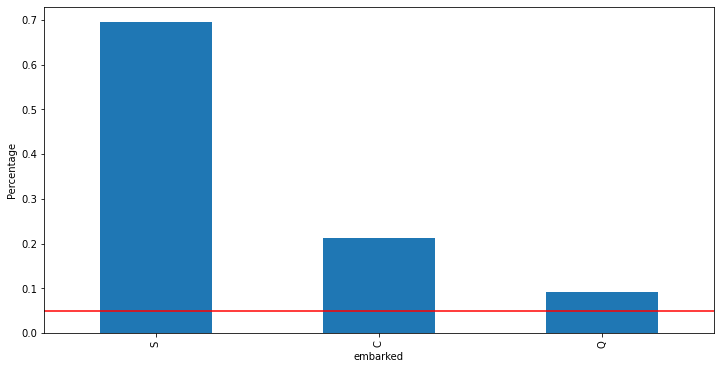

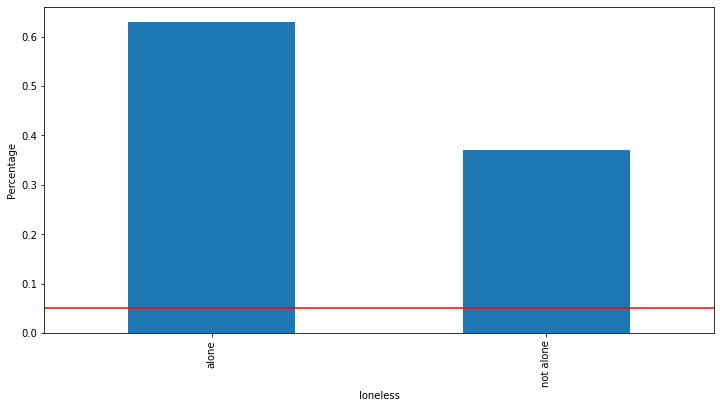

In [37]:
check_rare_labels(X_train, categorical)

     We don't need to handle rare labels in categorical features, all unique variables in features have count more then 5 percentage

## Encoding categorical features

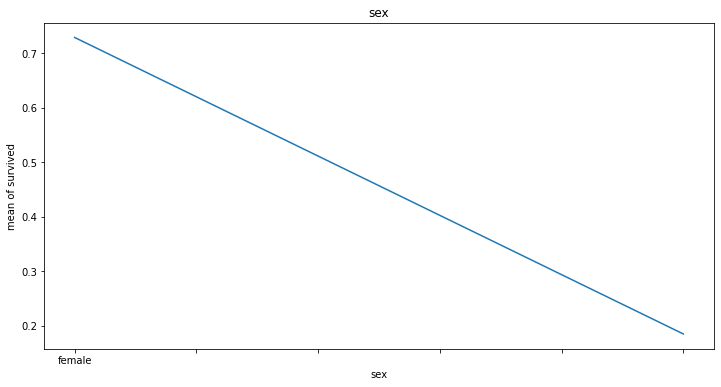

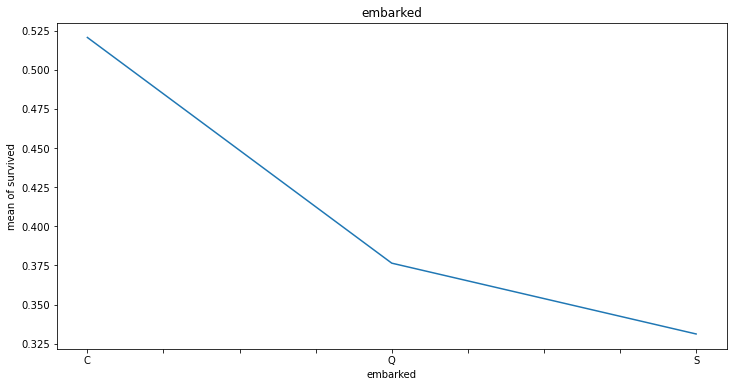

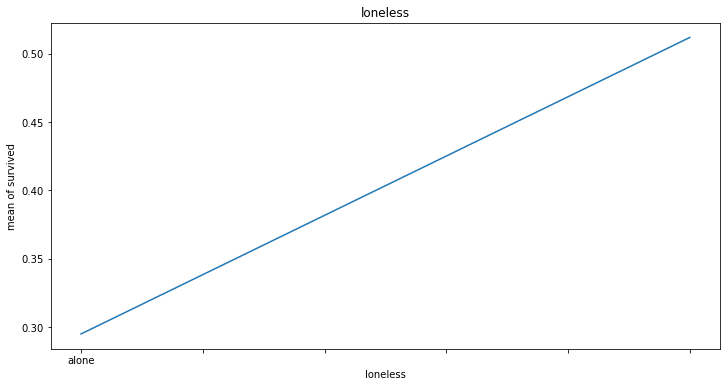

In [38]:
# Check relationships of our categorical features with target in train set

for var in categorical:
    check_relationship_with_target(X_train_imputed_random_sample, y_train, var)

     All categorical features have linear relationships with target with the exception of embarked
     that's why we can try to make them linear 

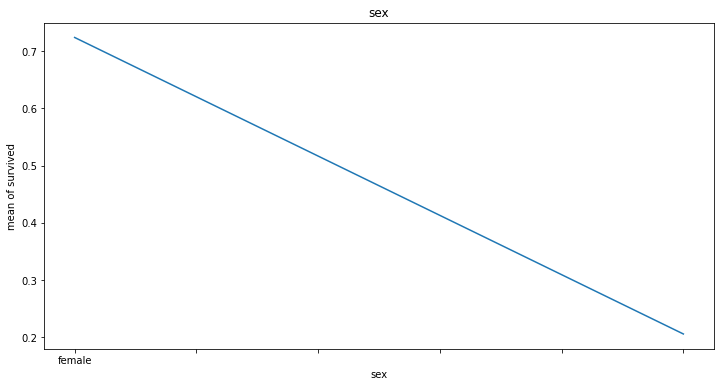

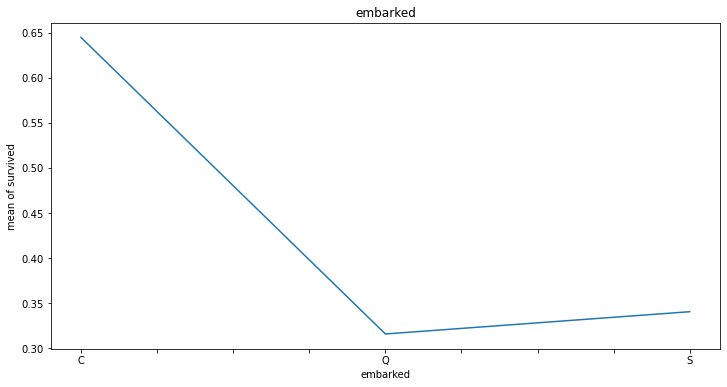

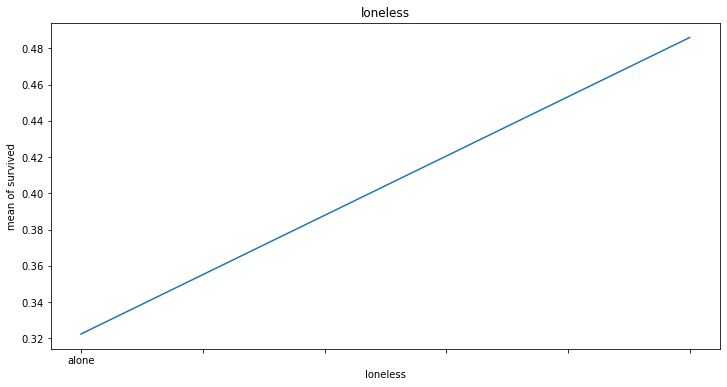

In [39]:
# Relationships with target in test set

for var in categorical:
    check_relationship_with_target(X_test_imputed_random_sample, y_test, var)

     The same situation with relationships in test set, so this method, are relevant for using

### Encoding feature: "embarked" to get monotonic relationships with target

In [40]:
enc_woe = WoEEncoder(variables = 'embarked')

enc_woe.fit(X_train_imputed_random_sample, y_train)

X_train_enc_woe = enc_woe.fit_transform(X_train_imputed_random_sample, y_train)

X_test_enc_woe = enc_woe.transform(X_test_imputed_random_sample)

     After using Weight of evidance encoding we also need to check relationships encoded feature with target in two sets

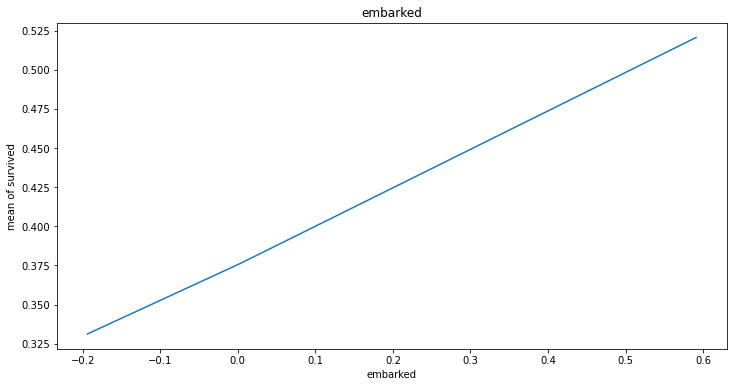

In [41]:
check_relationship_with_target(X_train_enc_woe, y_train, 'embarked')

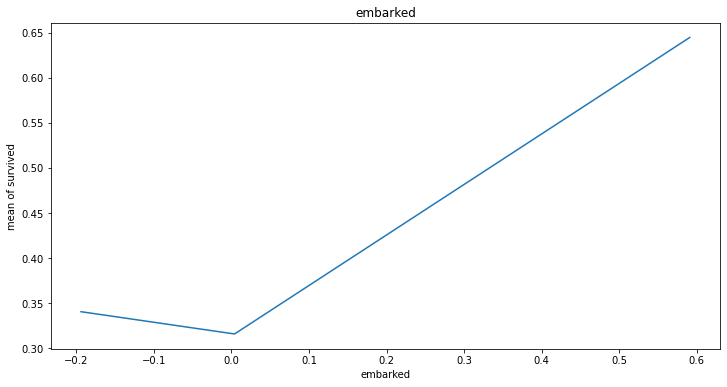

In [42]:
check_relationship_with_target(X_test_enc_woe, y_test, 'embarked')

     We got rid of the fracture in train set, but frature in test set the situation remains the same

     Assumtion: this data behavior we can't control

### Encoding categorical features that have monotonic relationships with target 

#### One hot encoding

In [43]:
X_train[categorical].nunique()

sex         2
embarked    3
loneless    2
dtype: int64

     Features that we will encode have low cardinality that is why don't tune parameter: top_categories

In [44]:
enc_ohe = OneHotEncoder(variables = ['sex', 'loneless'])

X_train_enc_ohe = enc_ohe.fit_transform(X_train_imputed_random_sample)

In [45]:
print('Shape of train set after One Hot Encoding: ', X_train_enc_ohe.shape)

print('Shape of train set before One hot encoding: ', X_train_imputed_random_sample.shape)

Shape of train set after One Hot Encoding:  (916, 8)
Shape of train set before One hot encoding:  (916, 6)


     Extend feature space on 2 positions, this is not critical, but there are some ML models that sensitive to feature space
     and we need to use another method of encoding 

### Ordinal encoding

In [46]:
enc_ord = OrdinalEncoder(encoding_method = 'arbitrary', variables = categorical)

X_train_enc_ord = enc_ord.fit_transform(X_train_imputed_random_sample)

In [47]:
for var in categorical:
    print(var, '\n Unique features before encoding', X_train_imputed_random_sample[var].unique(), '\n Unique features after encoding: ', X_train_enc_ord[var].unique(), '\n')

sex 
 Unique features before encoding ['male' 'female'] 
 Unique features after encoding:  [0 1] 

embarked 
 Unique features before encoding ['S' 'C' 'Q'] 
 Unique features after encoding:  [0 1 2] 

loneless 
 Unique features before encoding ['alone' 'not alone'] 
 Unique features after encoding:  [0 1] 



     After Ordinal encoding we get encode categorical features while not extending feature space

     Assumtion: we will use this method of encoding for categorical features with monotonic relationshipss

#### Make intermediate pipeline with perceived best practices

In [48]:
pipeline_inter = Pipeline(steps = [
    ('imputation', RandomSampleImputer(
        variables = categorical,
        random_state = 4
    )),
    ('encoding_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encodings_non_lin', WoEEncoder(variables = ['embarked']))
])

pipeline_inter.fit(X_train_imputed_random_sample, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(random_state=4,
                                     variables=['sex', 'embarked',
                                                'loneless'])),
                ('encoding_lin', OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encodings_non_lin', WoEEncoder(variables=['embarked']))])

In [49]:
# Create new sets without missing values and encoded categorical features

X_train_encoded_imputed = pipeline_inter.transform(X_train_imputed_random_sample)

X_test_encoded_imputed = pipeline_inter.transform(X_test_imputed_random_sample)

In [50]:
X_train_encoded_imputed.head(10)

,pclass,sex,age,fare,embarked,loneless
1132,3,0,22.0,7.8958,-0.194084,0
739,3,0,44.0,16.1000,-0.194084,1
1194,3,0,59.0,7.8958,-0.194084,0
766,3,0,25.0,7.8958,-0.194084,0
946,3,0,30.0,56.4958,-0.194084,0
645,3,0,23.0,7.7958,-0.194084,0
199,1,1,24.0,49.5042,0.591018,0
828,3,1,10.0,46.9000,-0.194084,1
219,1,0,29.0,25.7417,0.591018,0
320,1,0,5.0,35.5000,-0.194084,0


## Discretization continous features

### Equal-width discretization

In [51]:
# Redefine list of continous features 

continous = ['age', 'fare']

continous

['age', 'fare']

In [52]:
X_train.isnull().mean()

pclass      0.000000
sex         0.000000
age         0.212882
fare        0.000000
embarked    0.001092
loneless    0.000000
dtype: float64

In [53]:
disc_equal_width = EqualWidthDiscretiser(
    bins = 4,
    variables = continous
)

X_train_disc_width = disc_equal_width.fit_transform(X_train_encoded_imputed)

X_test_disc_width = disc_equal_width.transform(X_test_encoded_imputed)

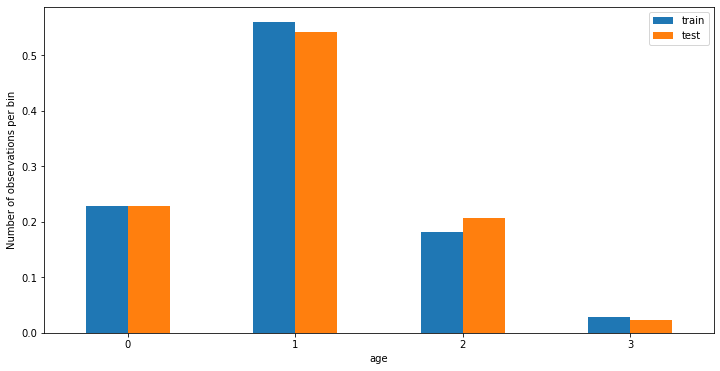

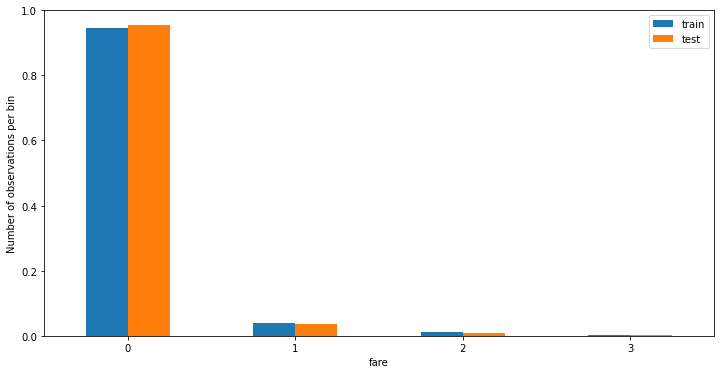

In [54]:
for var in continous:
    check_balance_of_discretized(X_train_disc_width, X_test_disc_width, var)

     We get normal balance of created classes in train and test sets, so we can use it in future work 

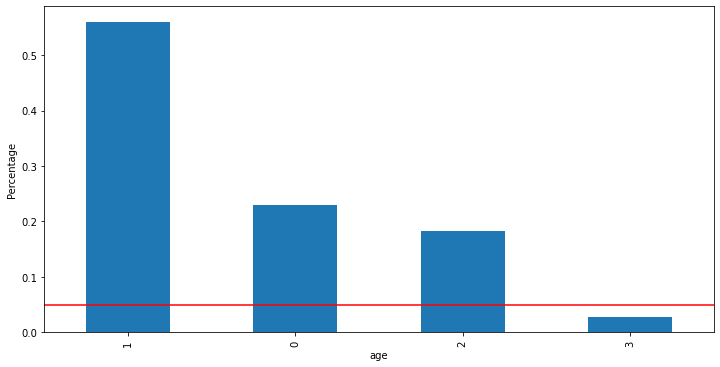

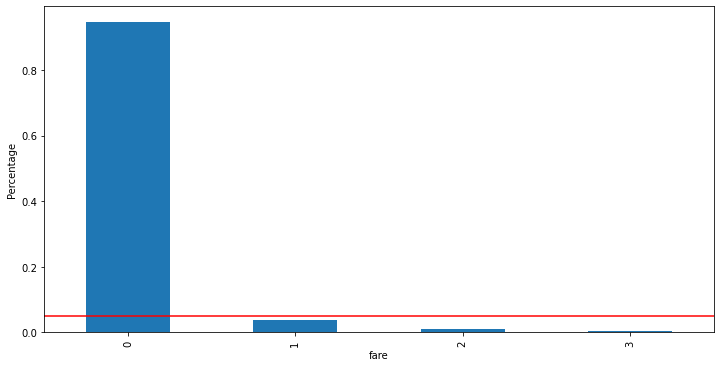

In [55]:
check_rare_labels(X_train_disc_width, continous)

     After discretization, rare values were formed 
     If we will use this method we need to integrate Rare labels encoder in pipeline 

### Equal-frequency discretization

In [56]:
disc_equal_frequency = EqualFrequencyDiscretiser(
    q = 4, 
    variables = continous,
    return_object = True 
)

X_train_disc_frequency = disc_equal_frequency.fit_transform(X_train_encoded_imputed)

X_test_disc_frequency = disc_equal_frequency.transform(X_test_encoded_imputed)

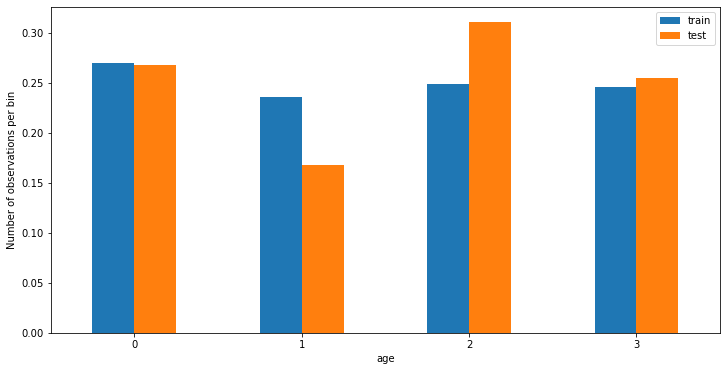

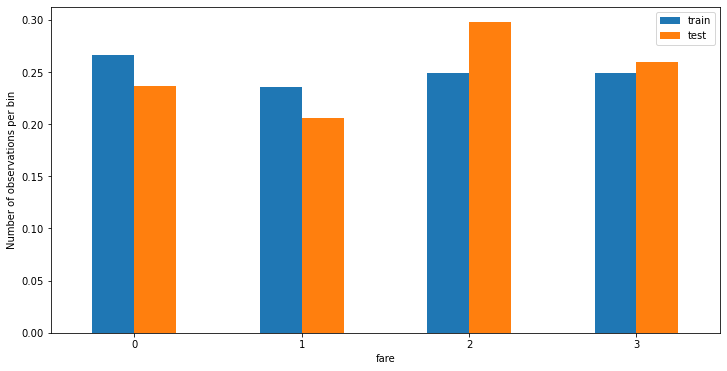

In [57]:
for var in continous:
    check_balance_of_discretized(X_train_disc_frequency, X_test_disc_frequency, var)

     Get permissible balancing of classes in train and test set

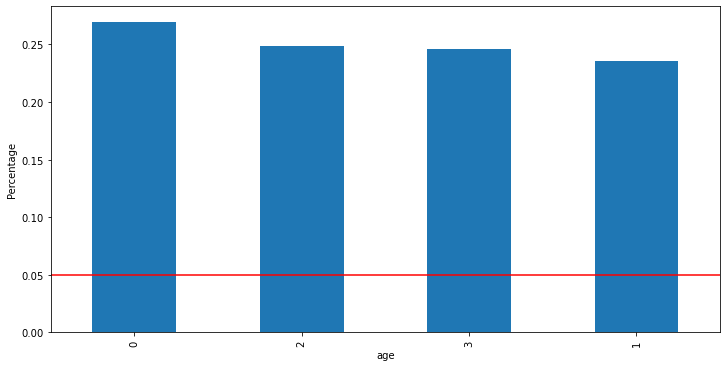

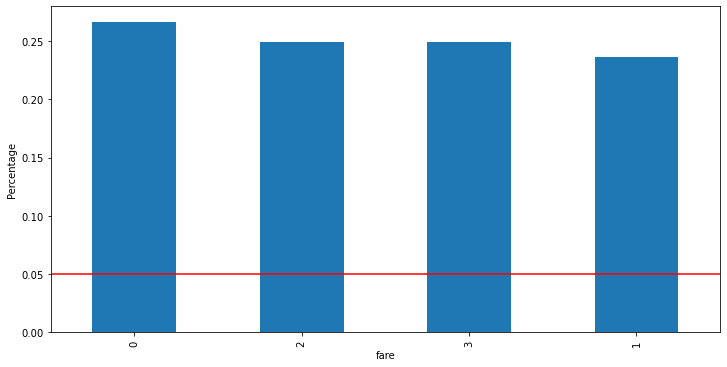

In [58]:
check_rare_labels(X_train_disc_frequency, continous)

     Using equal-frequency discretization don't reproduce rare labels

     After discretization we get discrete features and we need to encode them

## Encoding discretized features

     Should to check type of relationships between discretized features and target

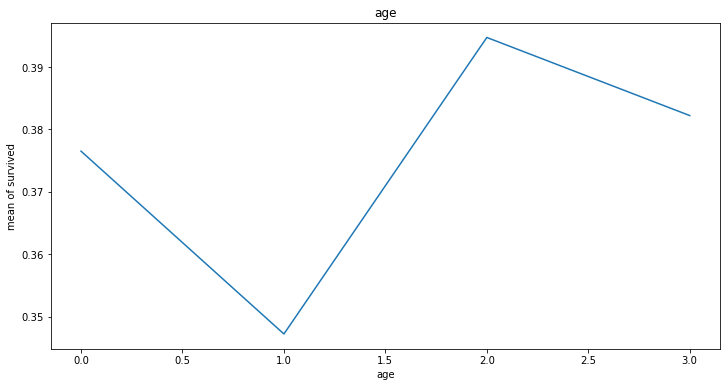

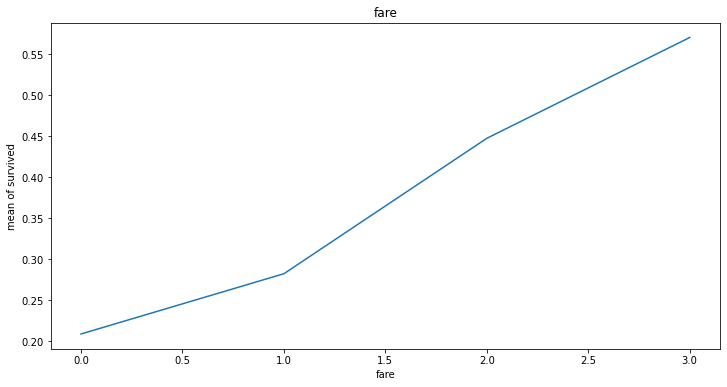

In [59]:
for var in continous:
    check_relationship_with_target(X_train_disc_frequency, y_train, var)

                Relationships aren't monotonic, that can influence the prediction, because monotonic relationships between predictors and target is one of the linear model assumptions

### Weight of evidance

In [60]:
# Redefine and refit Weight of evidance encoder for more handled sets

enc_woe = WoEEncoder(variables = continous)

X_train_enc_disc = enc_woe.fit_transform(X_train_disc_frequency, y_train)

X_test_enc_disc = enc_woe.transform(X_test_disc_frequency)

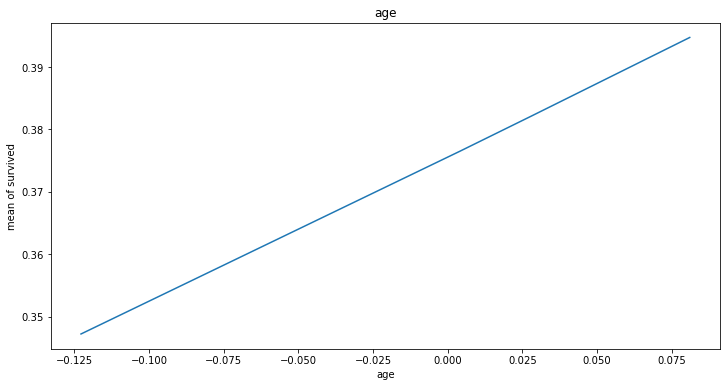

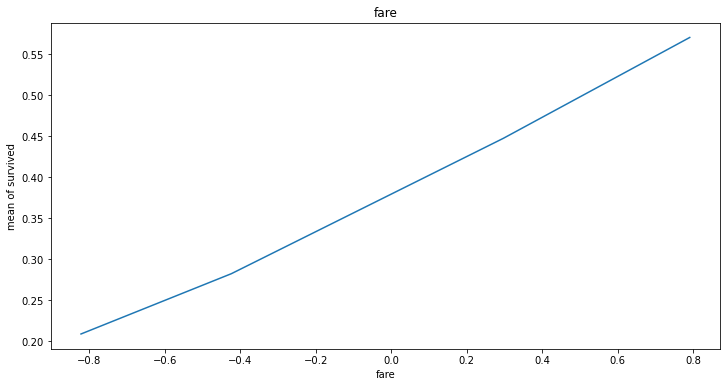

In [61]:
# Train set

for var in continous:
    check_relationship_with_target(X_train_enc_disc, y_train, var)

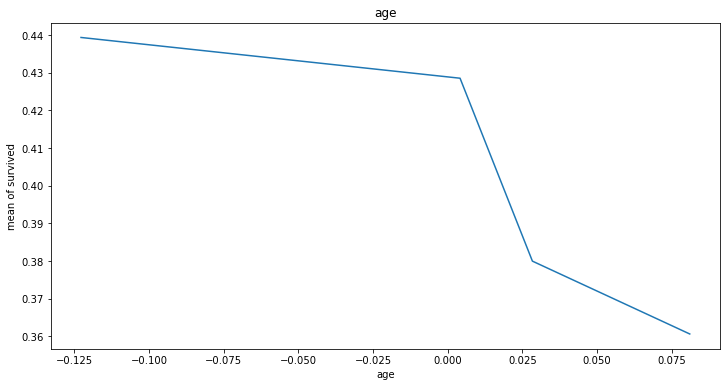

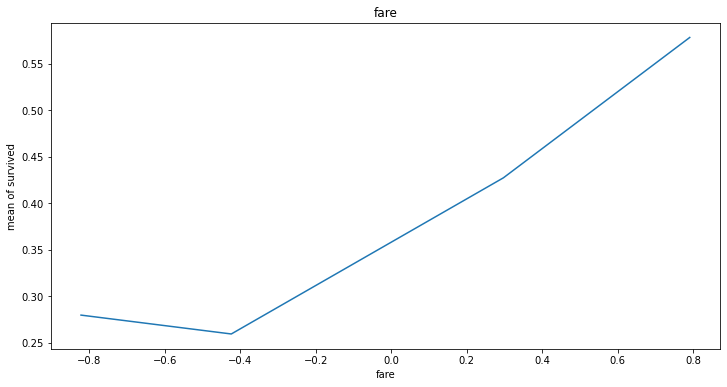

In [62]:
# Test set 

for var in continous:
    check_relationship_with_target(X_test_enc_disc, y_test, var)

     Get practically the same result, so we can use both of used techniques  

In [63]:
X_train_enc_disc

,pclass,sex,age,fare,embarked,loneless
1132,3,0,-0.122774,-0.822367,-0.194084,0
739,3,0,0.028371,0.297188,-0.194084,1
1194,3,0,0.028371,-0.822367,-0.194084,0
766,3,0,-0.122774,-0.822367,-0.194084,0
946,3,0,0.081053,0.791064,-0.194084,0
...,...,...,...,...,...,...
538,2,0,0.081053,-0.424054,0.591018,0
1169,3,0,0.028371,-0.822367,-0.194084,0
410,2,0,-0.122774,-0.822367,-0.194084,0
611,3,0,0.004144,-0.424054,-0.194084,1


     Our features are in different spaces and we need to convert them in same dimension

## Feature-scaling

### Robust scaling

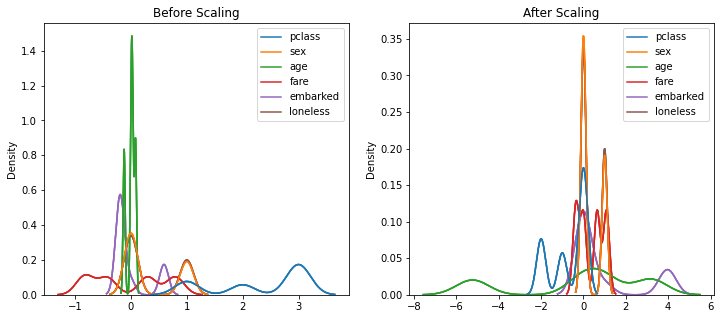

In [64]:
scaler_robust = RobustScaler()

scaler_robust.fit(X_train_enc_disc)

X_train_scaled_robust = scaler_robust.transform(X_train_enc_disc)

X_train_scaled_robust = pd.DataFrame(X_train_scaled_robust, columns = X_train_enc_disc.columns)

probplot_scaled(X_train_enc_disc, X_train_scaled_robust)

         Using robust scaling we get median that centered at zero, this property is well suited for SVC models

### Scaling to unit norm

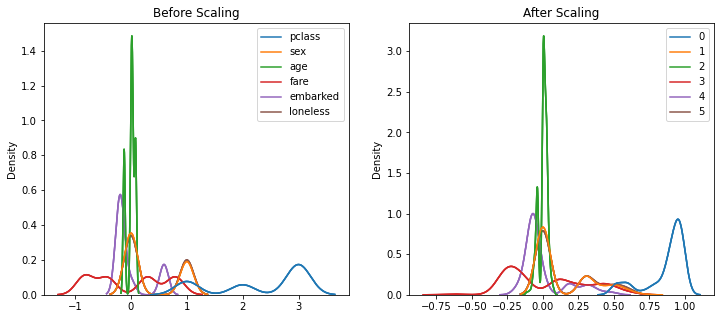

In [65]:
scaler_unit_norm = Normalizer()
scaler_unit_norm.fit(X_train_enc_disc)

X_train_scaled_unit_norm = scaler_unit_norm.transform(X_train_enc_disc)

X_train_scaled_robust = pd.DataFrame(X_train_scaled_unit_norm, columns = X_train_enc_disc.columns)


probplot_scaled(X_train_enc_disc, X_train_scaled_unit_norm)

     Method try to set normal disctribution for features

### Standartization

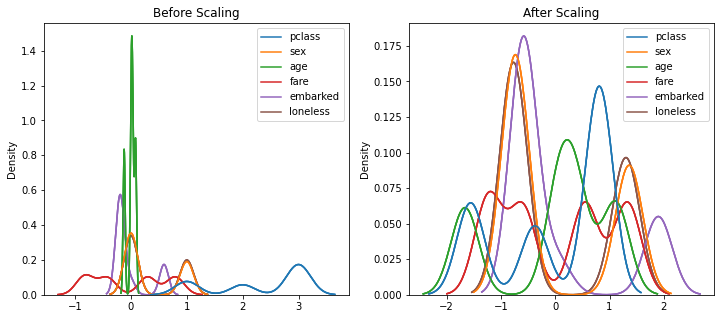

In [66]:
scaler_standart = StandardScaler()
scaler_standart.fit(X_train_enc_disc)

X_train_scaled_standartization = scaler_standart.transform(X_train_enc_disc)

X_train_scaled_standartization = pd.DataFrame(X_train_scaled_standartization, columns = X_train_enc_disc.columns)

probplot_scaled(X_train_enc_disc, X_train_scaled_standartization)

        We get an approximately normal distribution of variables

# Feature-selection

## Basic-filter methods

In [67]:
sel_const_variables = DropConstantFeatures(tol = 0.8, variables = None, missing_values = 'raise') 

sel_const_variables.fit(X_train_scaled_standartization)

sel_const_variables.features_to_drop_

[]

### Duplicated features

In [68]:
sel_duplicated_variables = DropDuplicateFeatures(variables = None, missing_values = 'raise')

sel_duplicated_variables.fit(X_train_scaled_standartization)

sel_duplicated_variables.features_to_drop_

set()

### Correlated features

In [69]:
sel_correlated_variables_variance = SmartCorrelatedSelection(
    variables = None, 
    method = 'pearson',
    threshold = 0.8,
    missing_values = 'raise',
    selection_method = 'variance',
    estimator = None,
    scoring = 'roc_auc',
    cv = 3
)

sel_correlated_variables_variance.fit(X_train_scaled_standartization, y_train)

sel_correlated_variables_variance.features_to_drop_

[]

        After using base filtered methods we couldn't determine features, that we can drop, so we don't use selection techniques in final pipeline

# Training models and tuning hyperparameters

## Decision tree

In [70]:
decision_tree = Pipeline(steps = [
    ('imputation', RandomSampleImputer(variables = ['age', 'fare', 'embarked'])),
    ('encoding_cat_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encoding_cat_non_lin', WoEEncoder(variables = ['embarked'])),
    ('discretization', EqualFrequencyDiscretiser(q = 4, variables = ['age', 'fare'], return_object = True)),
    ('encoding_disc_non_lin', WoEEncoder(variables = ['age', 'fare'])),
    ('clf', DecisionTreeClassifier())
])

decision_tree.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(variables=['age', 'fare', 'embarked'])),
                ('encoding_cat_lin',
                 OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encoding_cat_non_lin', WoEEncoder(variables=['embarked'])),
                ('discretization',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('encoding_disc_non_lin',
                 WoEEncoder(variables=['age', 'fare'])),
                ('clf', DecisionTreeClassifier())])

### Determine best parameters

#### RandomizedSearchCV

In [71]:
# To obtain approximate best values of the hyperparameters of the model,
# we use the RandomizedSearchCV, for their further use in GridSearch algorithm
# This algorithm of tuning we will use on all models that we will use for prediction 

rand_params = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__splitter': ['best', 'random'],
    'clf__max_depth': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)],
    'clf__min_samples_split': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)],
    'clf__min_samples_leaf': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)]
}

rand_search = RandomizedSearchCV(
    decision_tree,
    rand_params, 
    cv = 8, 
    n_iter = 100,
    verbose = 1,
    error_score = 'raise'
)

rand_search.fit(X_train, y_train)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


RandomizedSearchCV(cv=8, error_score='raise',
                   estimator=Pipeline(steps=[('imputation',
                                              RandomSampleImputer(variables=['age',
                                                                             'fare',
                                                                             'embarked'])),
                                             ('encoding_cat_lin',
                                              OrdinalEncoder(variables=['sex',
                                                                        'loneless'])),
                                             ('encoding_cat_non_lin',
                                              WoEEncoder(variables=['embarked'])),
                                             ('discretization',
                                              EqualFrequencyDiscretiser(q=4,
                                                                        return_object=True,
                                                                        variables=['age...
                                              WoEEncoder(variables=['age',
                                                                    'fare'])),
                                             ('clf',
                                              DecisionTreeClassifier())]),
                   n_iter=100,
                   param_distributions={'clf__criterion': ['gini', 'entropy',
                                                           'log_loss'],
                                        'clf__max_depth': [2, 7, 12, 18, 23, 28,
                                                           34, 39, 44, 50],
                                        'clf__min_samples_leaf': [2, 7, 12, 18,
                                                                  23, 28, 34,
                                                                  39, 44, 50],
                                        'clf__min_samples_split': [2, 7, 12, 18,
                                                                   23, 28, 34,
                                                                   39, 44, 50],
                                        'clf__splitter': ['best', 'random']},
                   verbose=1)

In [72]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)


# Delete don't needed characteristics for analysis hyperparameters

rs_df = rs_df.drop(labels = [
    'mean_fit_time', 
    'std_fit_time', 
    'mean_score_time',
    'std_score_time', 
    'params', 
    'split0_test_score', 
    'split1_test_score', 
    'split2_test_score',
    'split3_test_score',
    'split4_test_score',
    'split5_test_score',
    'split6_test_score',
    'split7_test_score',
    'std_test_score',
    'rank_test_score'
],
                   axis=1
                  )
rs_df.head(10)

,param_clf__splitter,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,param_clf__criterion,mean_test_score
0,best,34,2,50,entropy,0.805683
1,best,50,7,7,gini,0.804586
2,best,44,12,7,log_loss,0.804586
3,best,12,28,39,entropy,0.803499
4,best,28,12,7,gini,0.803471
5,best,18,34,7,entropy,0.802412
6,best,28,34,44,entropy,0.802412
7,best,28,28,18,entropy,0.802412
8,best,18,39,12,log_loss,0.802403
9,best,34,39,39,gini,0.802403


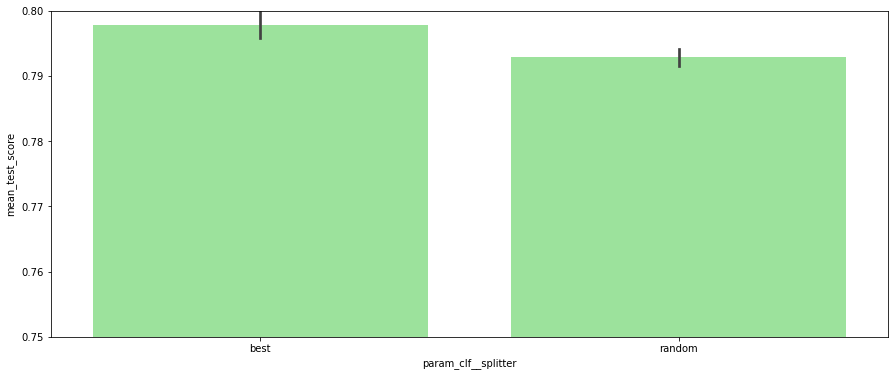

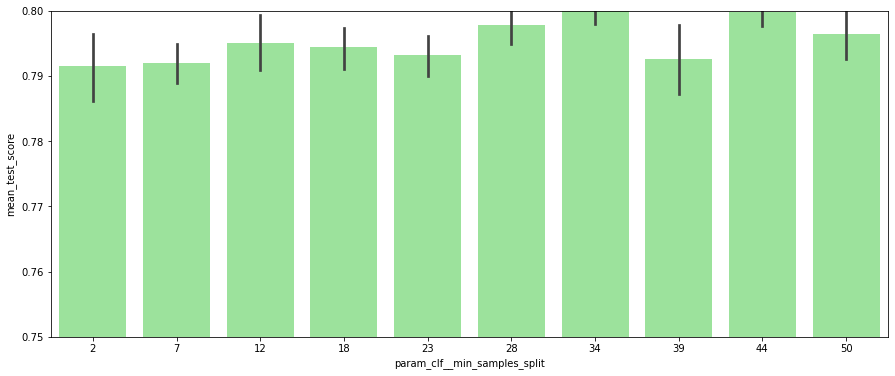

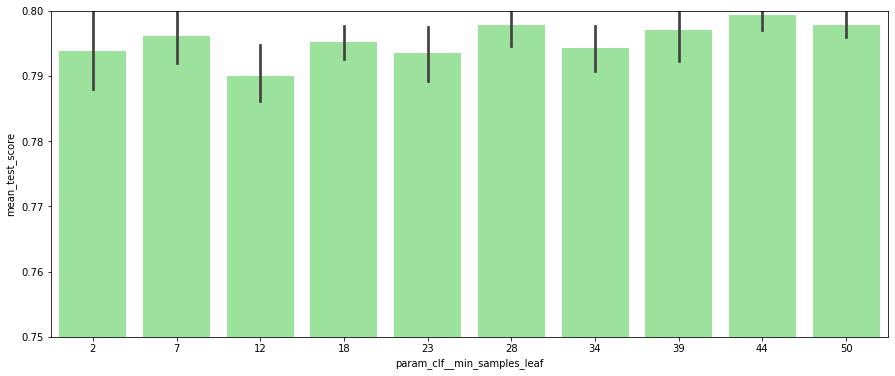

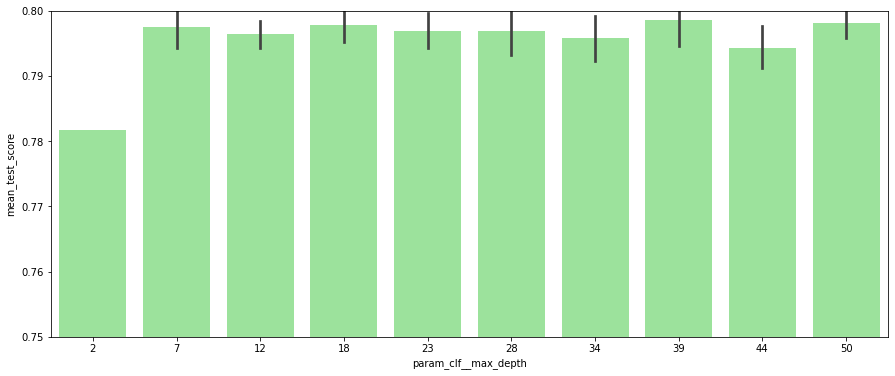

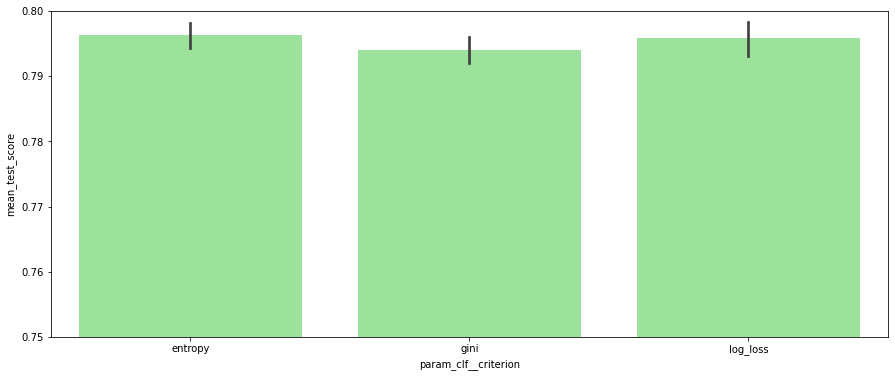

In [79]:
# Create list with names of columns in dataset, that contain information about set parameters by RandomizedSearchCV

list_of_hyper_names = rs_df.columns.to_list()

list_of_hyper_names.remove('mean_test_score')

for var in list_of_hyper_names:
    plt.figure(figsize = (15, 6))
    sns.barplot(x = var, y = 'mean_test_score', color = 'lightgreen', data = rs_df)
    plt.ylim(0.75, 0.8)
    
    plt.show()

                Getted approximate values of hyperparameters for Decision tree model. We will use best approximate areas to tune hyperparameters in GridSearch later. We will explore approximate values to get better model perfomance.
                Decision tree results by mean test score value varies 75% - 80%, so we set limit on graphic at this threshouls and search best hyperparameters areas.

#### GridSearch

In [80]:
grid_params = {
    'imputation__random_state': [int(var) for var in np.linspace(start = 1, stop = 10, num = 2)],
    'encoding_cat_lin': [
        OrdinalEncoder(variables = ['sex', 'loneless'], encoding_method = 'arbitrary'),
        OneHotEncoder(variables = ['sex', 'loneless'])
    ],
    'discretization__q': [var for var in range(2, 10)],
    'clf__splitter': ['best'],
    'clf__min_samples_split': [34, 44, 28],
    'clf__min_samples_leaf': [44, 50, 7, 28],
    'clf__max_depth': [39, 18, 7, 50],
    'clf__criterion': ['log_loss', 'entropy']
}

grid_search = GridSearchCV(
    decision_tree, 
    grid_params, 
    cv = 10, 
    error_score = 'raise'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('imputation',
                                        RandomSampleImputer(variables=['age',
                                                                       'fare',
                                                                       'embarked'])),
                                       ('encoding_cat_lin',
                                        OrdinalEncoder(variables=['sex',
                                                                  'loneless'])),
                                       ('encoding_cat_non_lin',
                                        WoEEncoder(variables=['embarked'])),
                                       ('discretization',
                                        EqualFrequencyDiscretiser(q=4,
                                                                  return_object=True,
                                                                  variables=['age',
                                                                             'fa...
             param_grid={'clf__criterion': ['log_loss', 'entropy'],
                         'clf__max_depth': [39, 18, 7, 50],
                         'clf__min_samples_leaf': [44, 50, 7, 28],
                         'clf__min_samples_split': [34, 44, 28],
                         'clf__splitter': ['best'],
                         'discretization__q': [2, 3, 4, 5, 6, 7, 8, 9],
                         'encoding_cat_lin': [OrdinalEncoder(encoding_method='arbitrary',
                                                             variables=['sex',
                                                                        'loneless']),
                                              OneHotEncoder(variables=['sex',
                                                                       'loneless'])],
                         'imputation__random_state': [1, 10]})

### Save tuned model and get results

In [81]:
# Saving model 

pickle.dump(
    grid_search.best_estimator_, 
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/decision_tree.pickle', 'wb')
)

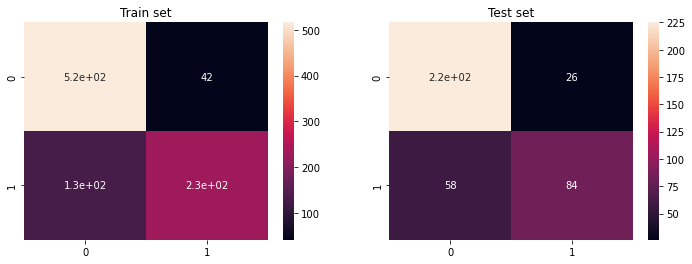

Classification report on train set
                precision    recall  f1-score   support

           0       0.80      0.92      0.86       558
           1       0.84      0.64      0.73       358

    accuracy                           0.81       916
   macro avg       0.82      0.78      0.79       916
weighted avg       0.82      0.81      0.81       916
 


Classification report on test set
                precision    recall  f1-score   support

           0       0.80      0.90      0.84       251
           1       0.76      0.59      0.67       142

    accuracy                           0.79       393
   macro avg       0.78      0.74      0.75       393
weighted avg       0.78      0.79      0.78       393



In [82]:
# Load decision tree model and get metrics score on it 
tuned_dt = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/decision_tree.pickle', 'rb')
)

get_score(tuned_dt)

## Random forest 

In [83]:
random_forest = Pipeline(steps = [
    ('imputation', RandomSampleImputer(variables = ['age', 'fare', 'embarked'])),
    ('encoding_cat_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encoding_cat_non_lin', WoEEncoder(variables = ['embarked'])),
    ('discretization', EqualFrequencyDiscretiser(q = 4, variables = ['age', 'fare'], return_object = True)),
    ('encoding_disc_non_lin', WoEEncoder(variables = ['age', 'fare'])),
    ('clf', RandomForestClassifier())
])

random_forest.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(variables=['age', 'fare', 'embarked'])),
                ('encoding_cat_lin',
                 OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encoding_cat_non_lin', WoEEncoder(variables=['embarked'])),
                ('discretization',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('encoding_disc_non_lin',
                 WoEEncoder(variables=['age', 'fare'])),
                ('clf', RandomForestClassifier())])

### Determine best parameters

#### RandomizedSearchCV

In [84]:
rand_params = {
    'clf__n_estimators': [int(var) for var in np.linspace(start = 50, stop = 1000, num = 20)],
    'clf__max_depth': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)],
    'clf__min_samples_split': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)],
    'clf__min_samples_leaf': [int(var) for var in np.linspace(start = 2, stop = 50, num = 10)],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__random_state': [int(var) for var in np.linspace(start = 1, stop = 1000, num = 20)],
    'clf__warm_start': [True, False]
}

rand_search = RandomizedSearchCV(
    random_forest,
    rand_params, 
    cv = 8, 
    n_iter = 100,
    verbose = 1,
    error_score = 'raise'
)

rand_search.fit(X_train, y_train)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


RandomizedSearchCV(cv=8, error_score='raise',
                   estimator=Pipeline(steps=[('imputation',
                                              RandomSampleImputer(variables=['age',
                                                                             'fare',
                                                                             'embarked'])),
                                             ('encoding_cat_lin',
                                              OrdinalEncoder(variables=['sex',
                                                                        'loneless'])),
                                             ('encoding_cat_non_lin',
                                              WoEEncoder(variables=['embarked'])),
                                             ('discretization',
                                              EqualFrequencyDiscretiser(q=4,
                                                                        return_object=True,
                                                                        variables=['age...
                                        'clf__min_samples_leaf': [2, 7, 12, 18,
                                                                  23, 28, 34,
                                                                  39, 44, 50],
                                        'clf__min_samples_split': [2, 7, 12, 18,
                                                                   23, 28, 34,
                                                                   39, 44, 50],
                                        'clf__n_estimators': [50, 100, 150, 200,
                                                              250, 300, 350,
                                                              400, 450, 500,
                                                              550, 600, 650,
                                                              700, 750, 800,
                                                              850, 900, 950,
                                                              1000],
                                        'clf__random_state': [1, 53, 106, 158,
                                                              211, 263, 316,
                                                              369, 421, 474,
                                                              526, 579, 631,
                                                              684, 737, 789,
                                                              842, 894, 947,
                                                              1000],
                                        'clf__warm_start': [True, False]},
                   verbose=1)

In [85]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)

rs_df = rs_df.drop(labels = [
    'mean_fit_time', 
    'std_fit_time', 
    'mean_score_time',
    'std_score_time', 
    'params', 
    'split0_test_score', 
    'split1_test_score', 
    'split2_test_score',
    'split3_test_score',
    'split4_test_score',
    'split5_test_score',
    'split6_test_score',
    'split7_test_score',
    'std_test_score',
    'rank_test_score'
],
                   axis=1
                  )
rs_df.head(10)

,param_clf__warm_start,param_clf__random_state,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,mean_test_score
0,False,684,900,39,7,None,39,0.807866
1,False,263,750,34,39,None,23,0.806808
2,True,947,150,18,18,None,12,0.805673
3,False,474,200,44,7,None,34,0.804596
4,False,947,850,39,12,None,23,0.804596
5,False,579,800,28,7,log2,7,0.804586
6,True,526,150,39,12,sqrt,28,0.803518
7,True,1000,400,12,2,sqrt,44,0.803509
8,False,1000,150,34,23,None,18,0.803499
9,False,789,200,50,39,None,12,0.802441


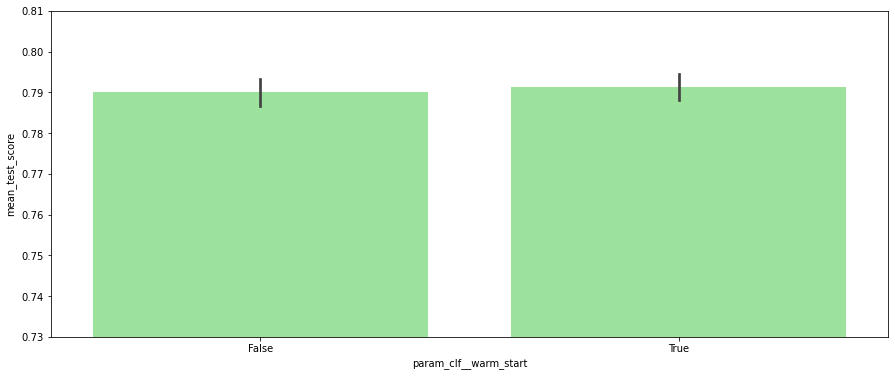

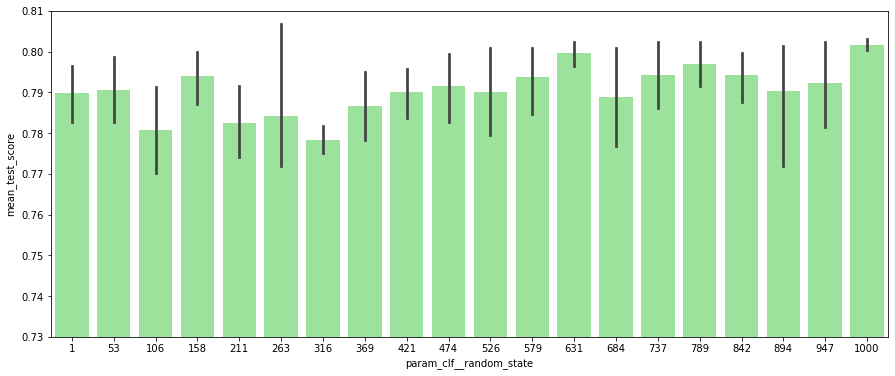

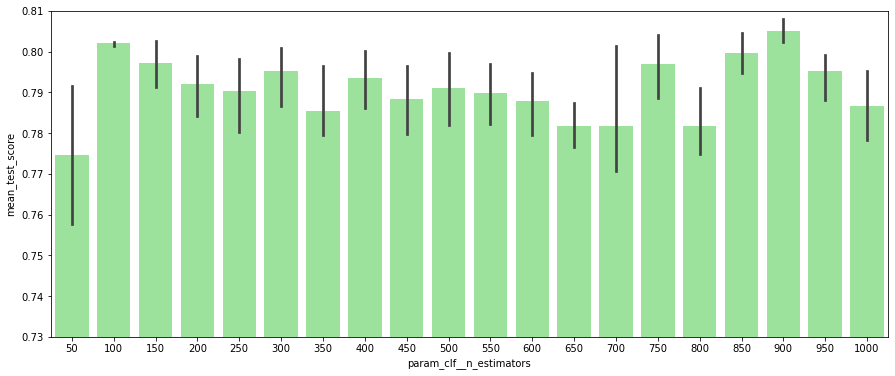

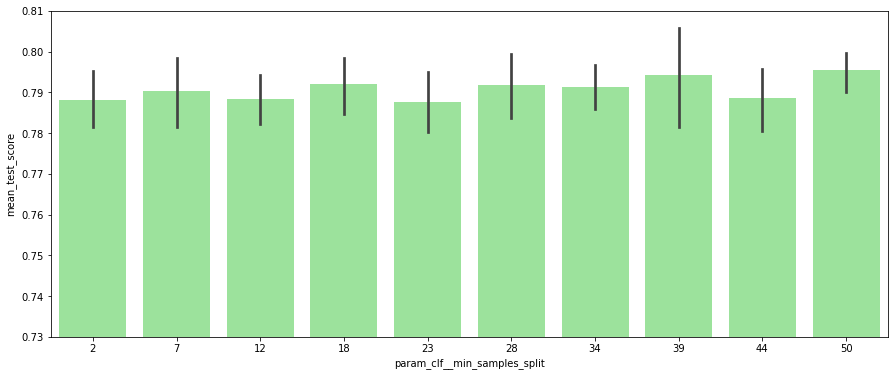

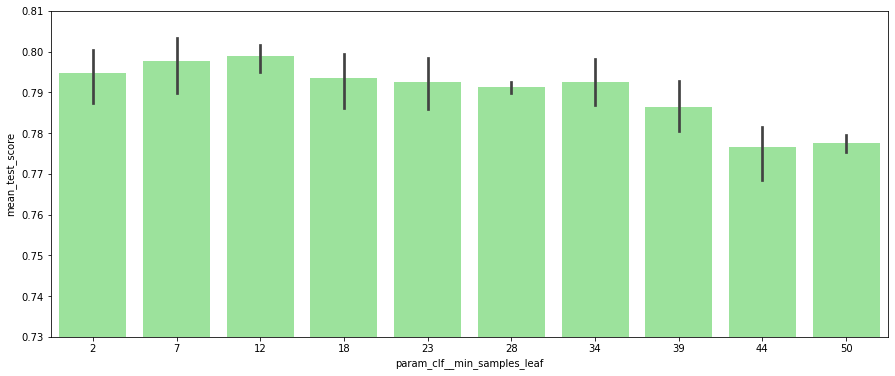

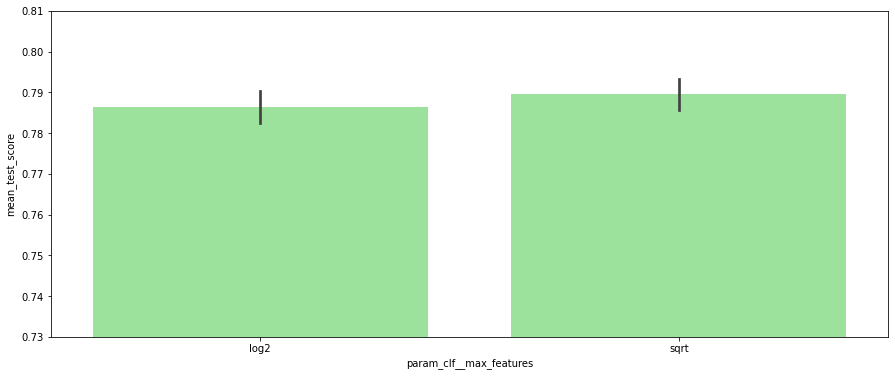

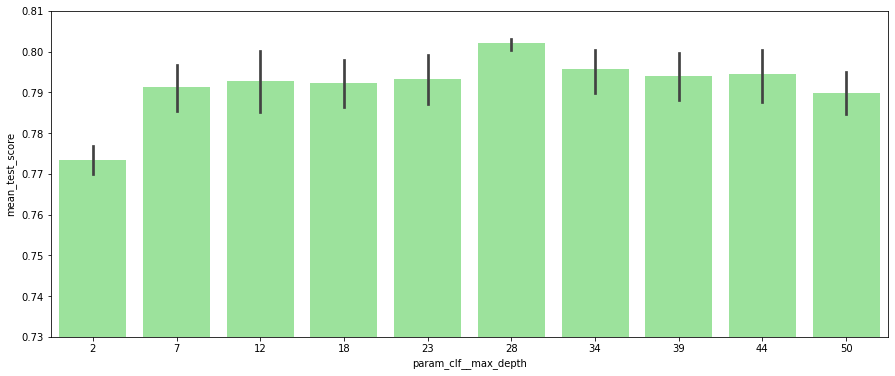

In [88]:
list_of_hyper_names = rs_df.columns.to_list()

list_of_hyper_names.remove('mean_test_score')

for var in list_of_hyper_names:
    plt.figure(figsize = (15, 6))
    sns.barplot(x = var, y = 'mean_test_score', color = 'lightgreen', data = rs_df)
    
    plt.ylim(0.73, 0.81)
        
    plt.show()

#### GridSearchCV

In [91]:
grid_params = {
    'imputation__random_state': [int(var) for var in np.linspace(start = 1, stop = 10, num = 2)],
    'encoding_cat_lin': [
        OrdinalEncoder(variables = ['sex', 'loneless'], encoding_method = 'arbitrary'),
        OneHotEncoder(variables = ['sex', 'loneless'])
    ],
    'discretization__q': [var for var in range(2, 10)],
    'clf__warm_start': [True],
    'clf__random_state': [1000, 158, 631, 789],
    'clf__n_estimators': [100, 750, 900],
    'clf__min_samples_split': [39, 50],
    'clf__min_samples_leaf': [7, 12],
    'clf__max_features': ['sqrt'],
    'clf__max_depth': [23, 28, 34]
}

grid_search = GridSearchCV(
    random_forest, 
    grid_params, 
    cv = 10, 
    error_score = 'raise',
    n_jobs = -1
    
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('imputation',
                                        RandomSampleImputer(variables=['age',
                                                                       'fare',
                                                                       'embarked'])),
                                       ('encoding_cat_lin',
                                        OrdinalEncoder(variables=['sex',
                                                                  'loneless'])),
                                       ('encoding_cat_non_lin',
                                        WoEEncoder(variables=['embarked'])),
                                       ('discretization',
                                        EqualFrequencyDiscretiser(q=4,
                                                                  return_object=True,
                                                                  variables=['age',
                                                                             'fa...
                         'clf__min_samples_leaf': [7, 12],
                         'clf__min_samples_split': [39, 50],
                         'clf__n_estimators': [100, 750, 900],
                         'clf__random_state': [1000, 158, 631, 789],
                         'clf__warm_start': [True],
                         'discretization__q': [2, 3, 4, 5, 6, 7, 8, 9],
                         'encoding_cat_lin': [OrdinalEncoder(encoding_method='arbitrary',
                                                             variables=['sex',
                                                                        'loneless']),
                                              OneHotEncoder(variables=['sex',
                                                                       'loneless'])],
                         'imputation__random_state': [1, 10]})

### Saving model with best determined hyperparameters and get metrics score on it

In [92]:
# Saving model 

pickle.dump(
    grid_search.best_estimator_, 
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/random_forest.pickle', 'wb')
)

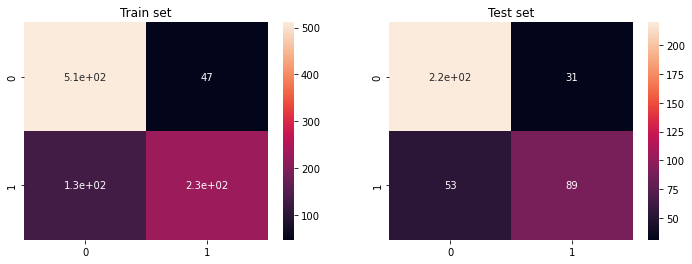

Classification report on train set
                precision    recall  f1-score   support

           0       0.80      0.92      0.85       558
           1       0.83      0.64      0.72       358

    accuracy                           0.81       916
   macro avg       0.81      0.78      0.79       916
weighted avg       0.81      0.81      0.80       916
 


Classification report on test set
                precision    recall  f1-score   support

           0       0.81      0.88      0.84       251
           1       0.74      0.63      0.68       142

    accuracy                           0.79       393
   macro avg       0.77      0.75      0.76       393
weighted avg       0.78      0.79      0.78       393



In [93]:
# Load model and get metrics score on it 
tuned_rf = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/random_forest.pickle', 'rb')
)

get_score(tuned_rf)

## Support vector classifier

In [70]:
svc = Pipeline(steps = [
    ('imputation', RandomSampleImputer(variables = ['age', 'fare', 'embarked'])),
    ('encoding_cat_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encoding_cat_non_lin', WoEEncoder(variables = ['embarked'])),
    ('discretization', EqualFrequencyDiscretiser(q = 4, variables = ['age', 'fare'], return_object = True)),
    ('encoding_disc_non_lin', WoEEncoder(variables = ['age', 'fare'])),
    ('scaling', RobustScaler()),
    ('clf', SVC())
])

svc.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(variables=['age', 'fare', 'embarked'])),
                ('encoding_cat_lin',
                 OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encoding_cat_non_lin', WoEEncoder(variables=['embarked'])),
                ('discretization',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('encoding_disc_non_lin',
                 WoEEncoder(variables=['age', 'fare'])),
                ('scaling', RobustScaler()), ('clf', SVC())])

### Determine best parameters

#### RandomizedSearchCV

In [73]:
rand_params = {
    'clf__C': [0.1, 0.5, 1, 5, 10, 20, 30, 40, 60, 100],
    'clf__gamma': ['scale', 'auto'],
    'clf__kernel': ['rbf', 'linear']
}

rand_search = RandomizedSearchCV(
    svc,
    rand_params, 
    cv = 8, 
    n_iter = 100,
    verbose = 1,
    error_score = 'raise',
    n_jobs = -1
)

rand_search.fit(X_train, y_train)

Fitting 8 folds for each of 40 candidates, totalling 320 fits


/Users/udzin/miniconda3/envs/KV-AI-JLM/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=8, error_score='raise',
                   estimator=Pipeline(steps=[('imputation',
                                              RandomSampleImputer(variables=['age',
                                                                             'fare',
                                                                             'embarked'])),
                                             ('encoding_cat_lin',
                                              OrdinalEncoder(variables=['sex',
                                                                        'loneless'])),
                                             ('encoding_cat_non_lin',
                                              WoEEncoder(variables=['embarked'])),
                                             ('discretization',
                                              EqualFrequencyDiscretiser(q=4,
                                                                        return_object=True,
                                                                        variables=['age',
                                                                                   'fare'])),
                                             ('encoding_disc_non_lin',
                                              WoEEncoder(variables=['age',
                                                                    'fare'])),
                                             ('scaling', RobustScaler()),
                                             ('clf', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__C': [0.1, 0.5, 1, 5, 10, 20, 30,
                                                   40, 60, 100],
                                        'clf__gamma': ['scale', 'auto'],
                                        'clf__kernel': ['rbf', 'linear']},
                   verbose=1)

In [74]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)

rs_df = rs_df.drop(labels = [
    'mean_fit_time', 
    'std_fit_time', 
    'mean_score_time',
    'std_score_time', 
    'params', 
    'split0_test_score', 
    'split1_test_score', 
    'split2_test_score',
    'split3_test_score',
    'split4_test_score',
    'split5_test_score',
    'split6_test_score',
    'split7_test_score',
    'std_test_score',
    'rank_test_score'
],
                   axis=1
                  )
rs_df.head(10)

,param_clf__kernel,param_clf__gamma,param_clf__C,mean_test_score
0,rbf,auto,10,0.789331
1,rbf,auto,20,0.787109
2,rbf,auto,0.5,0.787100
3,rbf,scale,40,0.786060
4,linear,auto,10,0.784926
5,linear,scale,100,0.784926
6,linear,auto,60,0.784926
7,linear,scale,60,0.784926
8,linear,auto,40,0.784926
9,linear,scale,40,0.784926


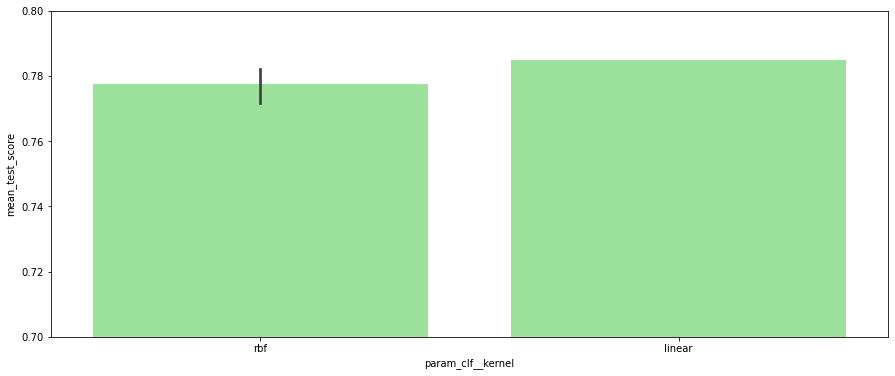

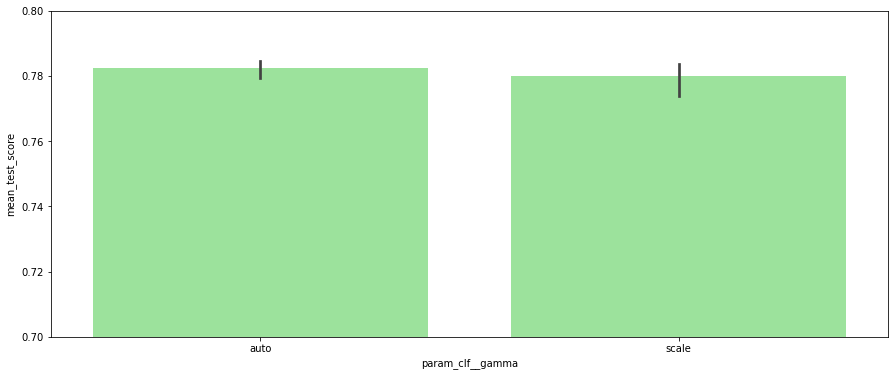

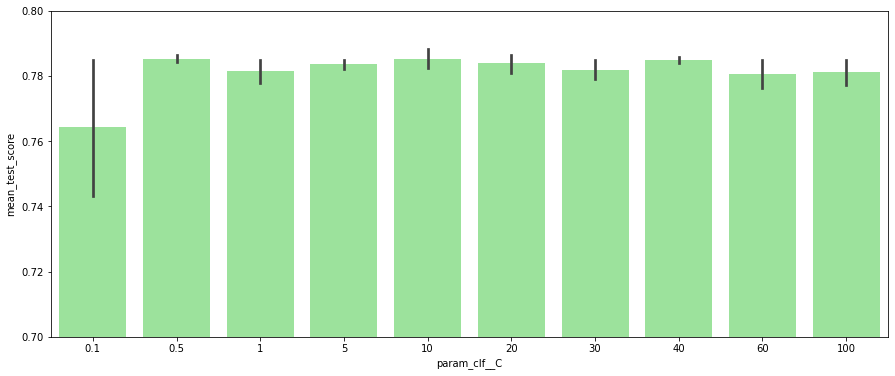

In [77]:
list_of_hyper_names = rs_df.columns.to_list()

list_of_hyper_names.remove('mean_test_score')

for var in list_of_hyper_names:
    
    plt.figure(figsize = (15, 6))
    sns.barplot(x = var, y = 'mean_test_score', color = 'lightgreen', data = rs_df)
    plt.ylim(0.7, 0.8)
        
    plt.show()

#### GridSearchCV

In [79]:
grid_params = {
    'imputation__random_state': [int(var) for var in np.linspace(start = 1, stop = 10, num = 2)],
    'encoding_cat_lin': [
        OrdinalEncoder(variables = ['sex', 'loneless'], encoding_method = 'arbitrary'),
        OneHotEncoder(variables = ['sex', 'loneless'])
    ],
    'discretization__q': [var for var in range(2, 10)],
    'scaling': [ 
        RobustScaler(),
        StandardScaler(),
        Normalizer()
    ],
    'clf__kernel': ['linear'],
    'clf__C': [0.5, 10, 20, 40],
    'clf__gamma': ['auto']
}

grid_search = GridSearchCV(
    svc,
    grid_params, 
    cv = 10, 
    error_score = 'raise',
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('imputation',
                                        RandomSampleImputer(variables=['age',
                                                                       'fare',
                                                                       'embarked'])),
                                       ('encoding_cat_lin',
                                        OrdinalEncoder(variables=['sex',
                                                                  'loneless'])),
                                       ('encoding_cat_non_lin',
                                        WoEEncoder(variables=['embarked'])),
                                       ('discretization',
                                        EqualFrequencyDiscretiser(q=4,
                                                                  return_object=True,
                                                                  variables=['age',
                                                                             'fa...
             param_grid={'clf__C': [0.5, 10, 20, 40], 'clf__gamma': ['auto'],
                         'clf__kernel': ['linear'],
                         'discretization__q': [2, 3, 4, 5, 6, 7, 8, 9],
                         'encoding_cat_lin': [OrdinalEncoder(encoding_method='arbitrary',
                                                             variables=['sex',
                                                                        'loneless']),
                                              OneHotEncoder(variables=['sex',
                                                                       'loneless'])],
                         'imputation__random_state': [1, 10],
                         'scaling': [RobustScaler(), StandardScaler(),
                                     Normalizer()]})

### Saving model and get results

In [80]:
# Saving model 

pickle.dump(
    grid_search.best_estimator_, 
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/svc.pickle', 'wb')
)

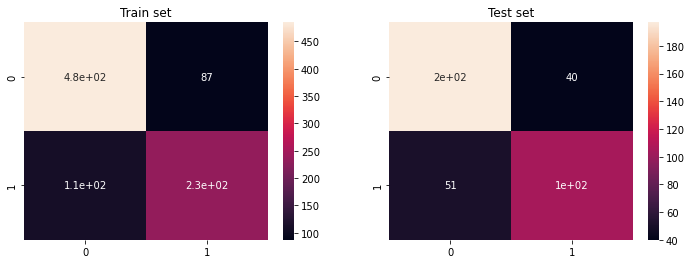

Classification report on train set
                precision    recall  f1-score   support

           0       0.82      0.85      0.83       572
           1       0.73      0.68      0.70       344

    accuracy                           0.78       916
   macro avg       0.77      0.76      0.77       916
weighted avg       0.78      0.78      0.78       916
 


Classification report on test set
                precision    recall  f1-score   support

           0       0.79      0.83      0.81       237
           1       0.72      0.67      0.70       156

    accuracy                           0.77       393
   macro avg       0.76      0.75      0.76       393
weighted avg       0.77      0.77      0.77       393



In [81]:
# Load model and get metrics score on it 
tuned_svc = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/svc.pickle', 'rb')
)

get_score(tuned_svc)

## AdaBoostClassifier

In [82]:
ada_boost = Pipeline(steps = [
    ('imputation', RandomSampleImputer(variables = ['age', 'fare', 'embarked'])),
    ('encoding_cat_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encoding_cat_non_lin', WoEEncoder(variables = ['embarked'])),
    ('discretization', EqualFrequencyDiscretiser(q = 4, variables = ['age', 'fare'], return_object = True)),
    ('encoding_disc_non_lin', WoEEncoder(variables = ['age', 'fare'])),
    ('clf', AdaBoostClassifier())
])

ada_boost.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(variables=['age', 'fare', 'embarked'])),
                ('encoding_cat_lin',
                 OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encoding_cat_non_lin', WoEEncoder(variables=['embarked'])),
                ('discretization',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('encoding_disc_non_lin',
                 WoEEncoder(variables=['age', 'fare'])),
                ('clf', AdaBoostClassifier())])

### Determine best parameters

#### RandomizedSearchCV

In [84]:
rand_params = {
    'clf__n_estimators': [int(var) for var in np.linspace(start = 50, stop = 1000, num = 20)],
    'clf__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'clf__algorithm': ['SAMME', 'SAMME.R']
}

rand_search = RandomizedSearchCV(
    ada_boost,
    rand_params, 
    cv = 8, 
    n_iter = 100,
    verbose = 1,
    error_score = 'raise',
    n_jobs = -1
)

rand_search.fit(X_train, y_train)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


RandomizedSearchCV(cv=8, error_score='raise',
                   estimator=Pipeline(steps=[('imputation',
                                              RandomSampleImputer(variables=['age',
                                                                             'fare',
                                                                             'embarked'])),
                                             ('encoding_cat_lin',
                                              OrdinalEncoder(variables=['sex',
                                                                        'loneless'])),
                                             ('encoding_cat_non_lin',
                                              WoEEncoder(variables=['embarked'])),
                                             ('discretization',
                                              EqualFrequencyDiscretiser(q=4,
                                                                        return_object=True,
                                                                        variables=['age',
                                                                                   'fare'])),
                                             ('encoding_disc_non_lin',
                                              WoEEncoder(variables=['age',
                                                                    'fare'])),
                                             ('clf', AdaBoostClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__algorithm': ['SAMME', 'SAMME.R'],
                                        'clf__learning_rate': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9],
                                        'clf__n_estimators': [50, 100, 150, 200,
                                                              250, 300, 350,
                                                              400, 450, 500,
                                                              550, 600, 650,
                                                              700, 750, 800,
                                                              850, 900, 950,
                                                              1000]},
                   verbose=1)

In [85]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)

rs_df = rs_df.drop(labels = [
    'mean_fit_time', 
    'std_fit_time', 
    'mean_score_time',
    'std_score_time', 
    'params', 
    'split0_test_score', 
    'split1_test_score', 
    'split2_test_score',
    'split3_test_score',
    'split4_test_score',
    'split5_test_score',
    'split6_test_score',
    'split7_test_score',
    'std_test_score',
    'rank_test_score'
],
                   axis=1
                  )
rs_df.head(10)

,param_clf__n_estimators,param_clf__learning_rate,param_clf__algorithm,mean_test_score
0,250,0.7,SAMME,0.786041
1,250,0.1,SAMME.R,0.786032
2,200,0.4,SAMME,0.784954
3,250,0.2,SAMME,0.784935
4,50,0.2,SAMME,0.783829
5,600,0.1,SAMME.R,0.782771
6,600,0.4,SAMME,0.781684
7,50,0.9,SAMME,0.781665
8,250,0.9,SAMME,0.781655
9,850,0.5,SAMME,0.781655


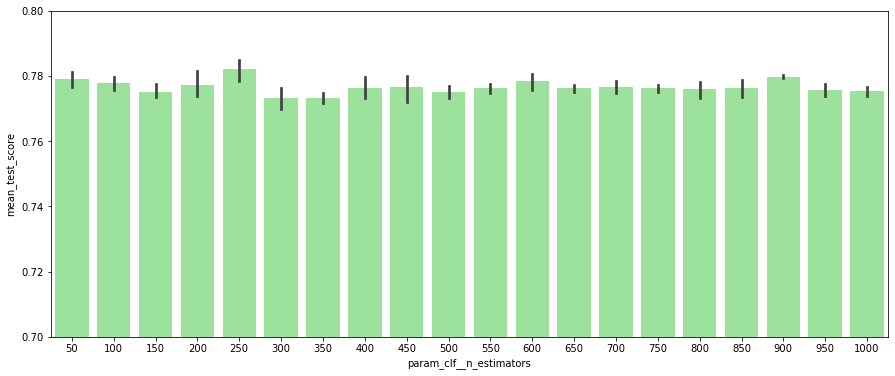

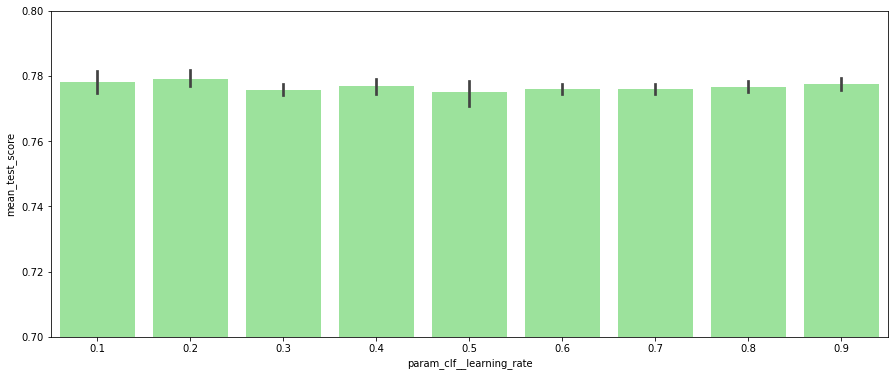

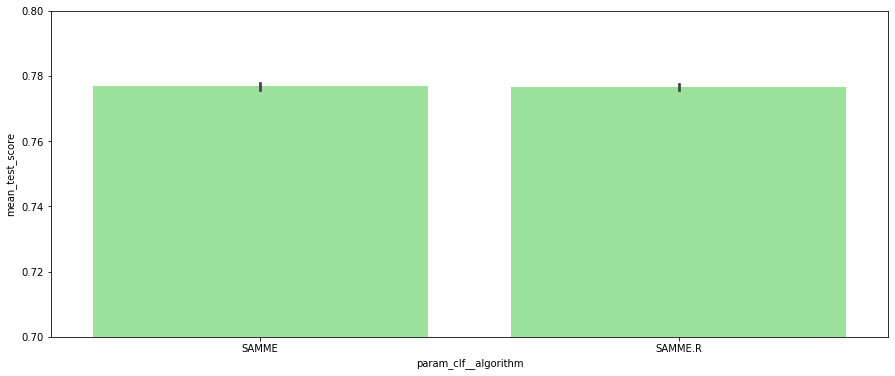

In [87]:
list_of_hyper_names = rs_df.columns.to_list()

list_of_hyper_names.remove('mean_test_score')

for var in list_of_hyper_names:
    
    plt.figure(figsize = (15, 6))
    sns.barplot(x = var, y = 'mean_test_score', color = 'lightgreen', data = rs_df)
    
    plt.ylim(0.7, 0.8)
    
    plt.show()

#### GridSearch

In [88]:
grid_params = {
    'imputation__random_state': [int(var) for var in np.linspace(start = 1, stop = 10, num = 2)],
    'encoding_cat_lin': [
        OrdinalEncoder(variables = ['sex', 'loneless'], encoding_method = 'arbitrary'),
        OneHotEncoder(variables = ['sex', 'loneless'])
    ],
    'discretization__q': [var for var in range(2, 10)],
    'clf__n_estimators': [250, 200, 450, 900],
    'clf__learning_rate': [0.2, 0.1, 0.9],
    'clf__algorithm': ['SAMME.R', 'SAMME']
}

grid_search = GridSearchCV(
    ada_boost, 
    grid_params, 
    cv = 10, 
    error_score = 'raise',
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('imputation',
                                        RandomSampleImputer(variables=['age',
                                                                       'fare',
                                                                       'embarked'])),
                                       ('encoding_cat_lin',
                                        OrdinalEncoder(variables=['sex',
                                                                  'loneless'])),
                                       ('encoding_cat_non_lin',
                                        WoEEncoder(variables=['embarked'])),
                                       ('discretization',
                                        EqualFrequencyDiscretiser(q=4,
                                                                  return_object=True,
                                                                  variables=['age',
                                                                             'fa...
                                       ('clf', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'clf__algorithm': ['SAMME.R', 'SAMME'],
                         'clf__learning_rate': [0.2, 0.1, 0.9],
                         'clf__n_estimators': [250, 200, 450, 900],
                         'discretization__q': [2, 3, 4, 5, 6, 7, 8, 9],
                         'encoding_cat_lin': [OrdinalEncoder(encoding_method='arbitrary',
                                                             variables=['sex',
                                                                        'loneless']),
                                              OneHotEncoder(variables=['sex',
                                                                       'loneless'])],
                         'imputation__random_state': [1, 10]})

### Saving model and get results

In [89]:
# Saving model 

pickle.dump(
    grid_search.best_estimator_, 
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/ada_boost.pickle', 'wb')
)

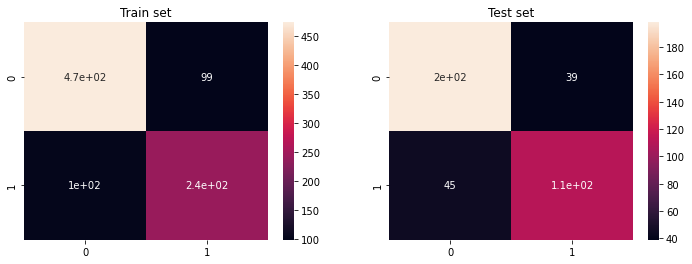

Classification report on train set
                precision    recall  f1-score   support

           0       0.82      0.83      0.82       572
           1       0.71      0.70      0.71       344

    accuracy                           0.78       916
   macro avg       0.77      0.77      0.77       916
weighted avg       0.78      0.78      0.78       916
 


Classification report on test set
                precision    recall  f1-score   support

           0       0.81      0.84      0.82       237
           1       0.74      0.71      0.73       156

    accuracy                           0.79       393
   macro avg       0.78      0.77      0.78       393
weighted avg       0.79      0.79      0.79       393



In [90]:
# Load model and get metrics score on it 
tuned_ada_boost = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/ada_boost.pickle', 'rb')
)

get_score(tuned_ada_boost)

## XGBoostClassifier

In [91]:
xgb = Pipeline(steps = [
    ('imputation', RandomSampleImputer(variables = ['age', 'fare', 'embarked'])),
    ('encoding_cat_lin', OrdinalEncoder(variables = ['sex', 'loneless'])),
    ('encoding_cat_non_lin', WoEEncoder(variables = ['embarked'])),
    ('discretization', EqualFrequencyDiscretiser(q = 4, variables = ['age', 'fare'], return_object = True)),
    ('encoding_disc_non_lin', WoEEncoder(variables = ['age', 'fare'])),
    ('scaling', StandardScaler()),
    ('clf', XGBClassifier())
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 RandomSampleImputer(variables=['age', 'fare', 'embarked'])),
                ('encoding_cat_lin',
                 OrdinalEncoder(variables=['sex', 'loneless'])),
                ('encoding_cat_non_lin', WoEEncoder(variables=['embarked'])),
                ('discretization',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('encoding_disc_non_lin',
                 WoEEncoder(variab...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

### Determine best parameters

#### RandomizedSearchCV

In [111]:
rand_params = {
    'clf__n_estimators': [int(var) for var in np.linspace(start = 100, stop = 1000, num = 50)],
    'clf__max_depth': [int(var) for var in np.linspace(start = 2, stop = 16, num = 8)],
    'clf__max_leaves': [int(var) for var in np.linspace(start = 0, stop = 10, num = 8)],
    'clf__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]
}

rand_search = RandomizedSearchCV(
    xgb,
    rand_params, 
    cv = 8, 
    n_iter = 100,
    verbose = 1,
    error_score = 'raise',
    n_jobs = -1
)

rand_search.fit(X_train, y_train)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


RandomizedSearchCV(cv=8, error_score='raise',
                   estimator=Pipeline(steps=[('imputation',
                                              RandomSampleImputer(variables=['age',
                                                                             'fare',
                                                                             'embarked'])),
                                             ('encoding_cat_lin',
                                              OrdinalEncoder(variables=['sex',
                                                                        'loneless'])),
                                             ('encoding_cat_non_lin',
                                              WoEEncoder(variables=['embarked'])),
                                             ('discretization',
                                              EqualFrequencyDiscretiser(q=4,
                                                                        return_object=True,
                                                                        variables=['age...
                                                            random_state=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9,
                                                               1.0, 2.0, 3.0],
                                        'clf__max_depth': [2, 4, 6, 8, 10, 12,
                                                           14, 16],
                                        'clf__max_leaves': [0, 1, 2, 4, 5, 7, 8,
                                                            10],
                                        'clf__n_estimators': [100, 118, 136,
                                                              155, 173, 191,
                                                              210, 228, 246,
                                                              265, 283, 302,
                                                              320, 338, 357,
                                                              375, 393, 412,
                                                              430, 448, 467,
                                                              485, 504, 522,
                                                              540, 559, 577,
                                                              595, 614, 632, ...]},
                   verbose=1)

In [112]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)

rs_df = rs_df.drop(labels = [
    'mean_fit_time', 
    'std_fit_time', 
    'mean_score_time',
    'std_score_time', 
    'params', 
    'split0_test_score', 
    'split1_test_score', 
    'split2_test_score',
    'split3_test_score',
    'split4_test_score',
    'split5_test_score',
    'split6_test_score',
    'split7_test_score',
    'std_test_score',
    'rank_test_score'
],
                   axis=1
                  )
rs_df.head(10)

,param_clf__n_estimators,param_clf__max_leaves,param_clf__max_depth,param_clf__learning_rate,mean_test_score
0,118,8,12,0.4,0.802317
1,448,1,14,1.0,0.796920
2,283,7,14,0.2,0.796920
3,504,1,6,0.2,0.796901
4,522,10,16,0.8,0.795814
5,632,8,10,0.1,0.793659
6,889,1,12,0.3,0.793659
7,871,5,12,0.6,0.793659
8,246,4,12,1.0,0.793659
9,338,7,16,0.8,0.793640


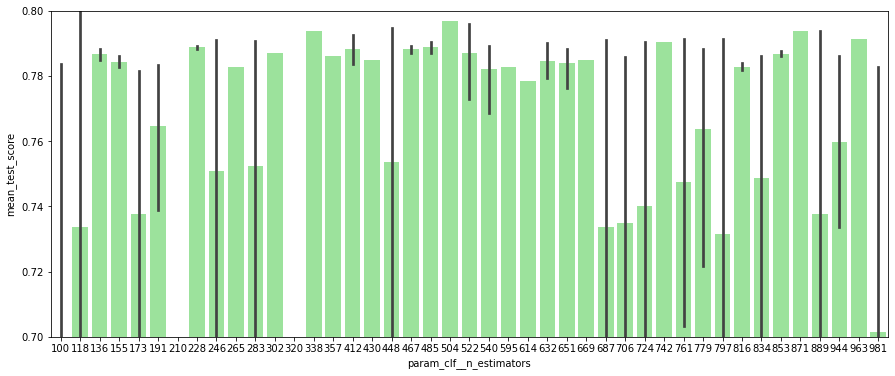

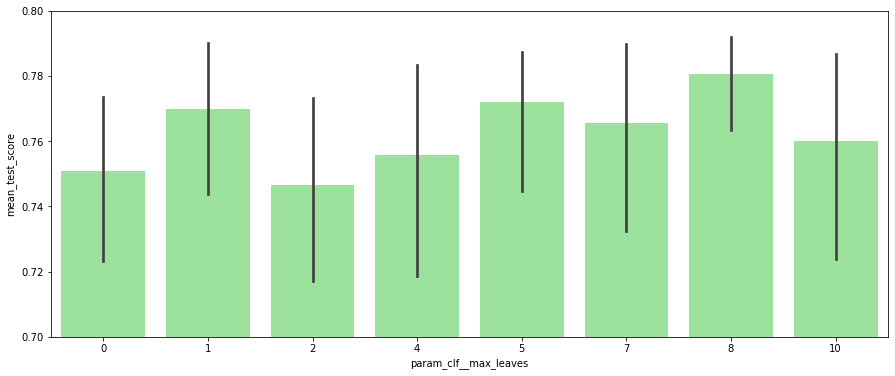

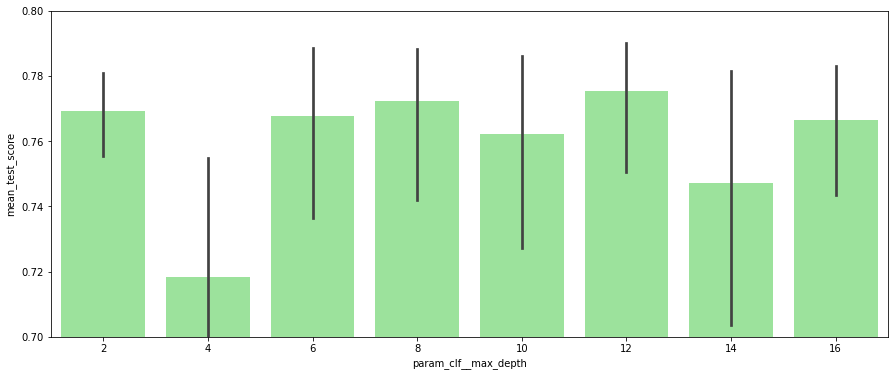

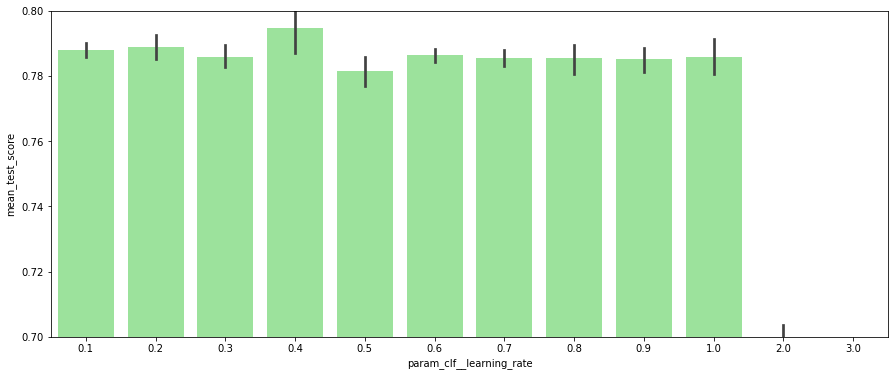

In [114]:
list_of_hyper_names = rs_df.columns.to_list()

list_of_hyper_names.remove('mean_test_score')

for var in list_of_hyper_names:
    
    plt.figure(figsize = (15, 6))
    sns.barplot(x = var, y = 'mean_test_score', color = 'lightgreen', data = rs_df)
    
    plt.ylim(0.7, 0.8)
    
    plt.show()

#### GridSearchCV

In [115]:
grid_params = {
    'imputation__random_state': [int(var) for var in np.linspace(start = 1, stop = 10, num = 2)],
    'encoding_cat_lin': [
        OrdinalEncoder(variables = ['sex', 'loneless'], encoding_method = 'arbitrary'),
        OneHotEncoder(variables = ['sex', 'loneless'])
    ],
    'discretization__q': [var for var in range(2, 10)],
    'scaling': [
        RobustScaler(),
        StandardScaler(),
        Normalizer()
    ],
    'clf__n_estimators': [338, 504, 480, 742],
    'clf__max_depth': [6, 8, 12, 2, 16],
    'clf__max_leaves': [1, 5, 8],
    'clf__learning_rate': [0.4, 0.2, 0.8]
}

grid_search = GridSearchCV(
    xgb, 
    grid_params, 
    cv = 10, 
    error_score = 'raise',
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('imputation',
                                        RandomSampleImputer(variables=['age',
                                                                       'fare',
                                                                       'embarked'])),
                                       ('encoding_cat_lin',
                                        OrdinalEncoder(variables=['sex',
                                                                  'loneless'])),
                                       ('encoding_cat_non_lin',
                                        WoEEncoder(variables=['embarked'])),
                                       ('discretization',
                                        EqualFrequencyDiscretiser(q=4,
                                                                  return_object=True,
                                                                  variables=['age',
                                                                             'fa...
                         'clf__max_depth': [6, 8, 12, 2, 16],
                         'clf__max_leaves': [1, 5, 8],
                         'clf__n_estimators': [338, 504, 480, 742],
                         'discretization__q': [2, 3, 4, 5, 6, 7, 8, 9],
                         'encoding_cat_lin': [OrdinalEncoder(encoding_method='arbitrary',
                                                             variables=['sex',
                                                                        'loneless']),
                                              OneHotEncoder(variables=['sex',
                                                                       'loneless'])],
                         'imputation__random_state': [1, 10],
                         'scaling': [RobustScaler(), StandardScaler(),
                                     Normalizer()]})

### Save model and get resuts

In [116]:
# Saving model 

pickle.dump(
    grid_search.best_estimator_, 
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/xgb.pickle', 'wb')
)

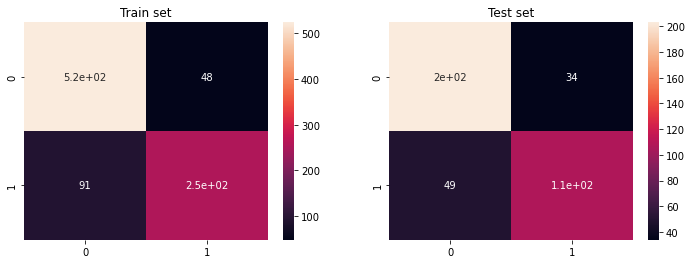

Classification report on train set
                precision    recall  f1-score   support

           0       0.85      0.92      0.88       572
           1       0.84      0.74      0.78       344

    accuracy                           0.85       916
   macro avg       0.85      0.83      0.83       916
weighted avg       0.85      0.85      0.85       916
 


Classification report on test set
                precision    recall  f1-score   support

           0       0.81      0.86      0.83       237
           1       0.76      0.69      0.72       156

    accuracy                           0.79       393
   macro avg       0.78      0.77      0.78       393
weighted avg       0.79      0.79      0.79       393



In [117]:
# Load model and get results

tuned_xgb = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/xgb.pickle', 'rb')
)

get_score(tuned_xgb)

## Results

In [118]:
# Load saved models

tuned_dt = pickle.load(
    open(
        '/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/decision_tree.pickle',
         'rb'
    )
)
    
tuned_rf = pickle.load(
    open(
        '/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/random_forest.pickle',
         'rb'
    )
)


tuned_svc = pickle.load(
    open(
        '/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/svc.pickle',
         'rb'
    )
)


tuned_ada = pickle.load(
    open(
        '/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/ada_boost.pickle',
         'rb'
    )
)

tuned_xgb = pickle.load(
    open('/Users/udzin/Desktop/Projects/Project_1/Titanic_classification/Titanic_models/xgb.pickle', 'rb')
)

In [119]:
# Create Dataframe with models results

models = [
    tuned_dt,
    tuned_rf, 
    tuned_svc, 
    tuned_ada,
    tuned_xgb
]

models_roc_auc_train = list()
models_roc_auc_test = list()

models_accuracy_train = list()
models_accuracy_test = list()

models_names = list()


for var in models:
    
    models_names.append(type(var[-1]).__name__)
    
    models_roc_auc_train.append(np.round(roc_auc_score(y_train ,var.predict(X_train)) * 100, 2))
    models_roc_auc_test.append(np.round(roc_auc_score(y_test, var.predict(X_test)) * 100, 2))
    
    models_accuracy_train.append(np.round(accuracy_score(y_train, var.predict(X_train)) * 100, 2))
    models_accuracy_test.append(np.round(accuracy_score(y_test, var.predict(X_test)) * 100, 2))

In [120]:
# Create dataframe with results

results = pd.DataFrame({
    'roc_auc_train': models_roc_auc_train,
    'roc_auc_test': models_roc_auc_test,
    'accuracy_train': models_accuracy_train,
    'accuracy_test': models_accuracy_test
}, index = models_names)

# Transpose the dataframe

results = results.T

In [121]:
results

,DecisionTreeClassifier,RandomForestClassifier,SVC,AdaBoostClassifier,XGBClassifier
roc_auc_train,75.86,76.15,76.41,76.52,82.58
roc_auc_test,78.59,78.48,75.22,77.35,77.12
accuracy_train,79.91,79.69,78.49,78.06,84.83
accuracy_test,80.92,80.92,76.84,78.63,78.88


In [122]:
# Check corectness of obtained data


print('Obtained decision tree values: \n\n', results['DecisionTreeClassifier'], '\n')

print(
    'Actual decision tree values: \n\n roc_auc_train: {:.2f} roc_auc_test: {:.2f}, accuracy_train: {:.2f}, accuracy_test: {:.2f}'
    .format( 
        np.round(roc_auc_score(y_train, tuned_dt.predict(X_train)) * 100, 2),
        np.round(roc_auc_score(y_test, tuned_dt.predict(X_test)) * 100, 2),
        np.round(accuracy_score(y_train, tuned_dt.predict(X_train)) * 100, 2),
        np.round(accuracy_score(y_test, tuned_dt.predict(X_test)) * 100, 2)
))

Obtained decision tree values: 

 roc_auc_train     75.86
roc_auc_test      78.59
accuracy_train    79.91
accuracy_test     80.92
Name: DecisionTreeClassifier, dtype: float64 

Actual decision tree values: 

 roc_auc_train: 75.86 roc_auc_test: 78.59, accuracy_train: 79.91, accuracy_test: 80.92


      Obtained results and actual are the same, so we can conclude, that data in dataset "results" were obtained correctly

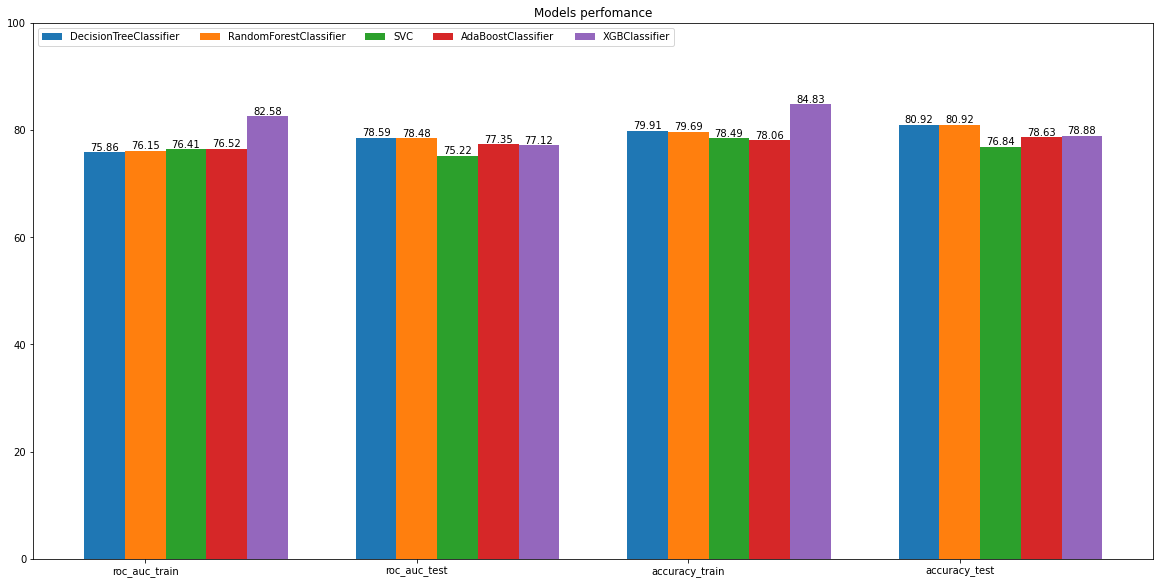

In [125]:
plt.rcParams['figure.figsize'] = (16, 8)

fig, ax = plt.subplots(layout = 'constrained')

width = 0.15

multiplier = 0


for i, j in results.items():
    
    offset = width * multiplier
    rects = ax.bar(np.arange(len(results)) + offset, j, width, label = i)
    ax.bar_label(rects)
    multiplier += 1
    

ax.set_title('Models perfomance')
ax.set_xticks(np.arange(len(results)) + width, results.index)
ax.legend(loc = 'upper left', ncols = 5)
ax.set_ylim(0, 100)


plt.show()

# Conclusion

         As a result of the work carried out, it can be concluded that the decision tree and the random forest are the best models, although they do not have the highest performance in terms of metrics, but they are the most stable
         Model XGBoost was overfitted, but maybe we can get better result if change data preprocessing techniques or better find hyperparameters.